---
 
# **EZAU FARIDH TORRES TORRES**

     
<p align="right"> Maestría en Ciencias con Orientación en Matemáticas Aplicadas. </p>
<p align="right"> Fecha: 10/08/2025. </p>

---

**Contexto:**
Una aseguradora ha recopilado información categórica sobre sus clientes y pólizas. Cada fila representa un caso individual, y `FraudFound_P` indica si el caso fue fraudulento (fraude = 1) o no (fraude = 0). El evento de fraude es de baja frecuencia.
 
**Objetivo:**
Diseñar un pipeline completo de procesamiento y modelado de datos que permita detectar posibles fraudes, utilizando técnicas tradicionales de modelado y disponibilizando el modelo final como un servicio de scoring.
 
**Preprocesamiento de Datos y Modelado Predictivo:**
- Detección y tratamiento de duplicados, conformidad de los valores categóricos, tratamiento de valores ausentes y EDA.
- Desarrollar al menos un modelo tradicional de regresión logística utilizando transformación entrópica y generación de una scorecard, mostrar para cada variable las categorías y los puntos asignados.
- Se pueden proponer y justificar enfoques adicionales (árboles, boosting, etc.), pero el modelo con WoE y scorecard es obligatorio.
 
**Evaluación del Modelo:**
- Métricas de desempeño (AUC, KS, matriz de confusión, etc.).
- Justificación del modelo champion seleccionado.
 
**Despliegue del Modelo:**
Crear un servicio (puede ser una API REST o una demo funcional) que permita:
- Ingresar los datos de un cliente, obtener el score de riesgo de fraude y documentar cómo utilizar el servicio.
 
**Entregables:**
- Código fuente del pipeline completo (formato ipynb y pdf).
- Scorecard con detalle de puntos por categoría.
- Documentación técnica del modelo y del servicio.
- Instrucciones para ejecutar la demo o consumir la API.
- Presentación de resultados.

#### **Necessary libraries.**

In [2]:
# !pip install scikit-learn numpy pandas ...
import pandas as pd                                  # library for data manipulation and analysis.
from pandas.api.types import CategoricalDtype        # for categorical data types.
import numpy as np                                   # library for numerical computing.
from pathlib import Path                             # library for filesystem paths.
import matplotlib.pyplot as plt                      # library for data visualization.
import seaborn as sns                                # library for statistical data visualization.
import json                                          # 
import os                                            # library for operating system interactions.     
sns.set_style("darkgrid")                            # set style for seaborn.
from typing import Tuple, Optional, Dict, Any        # library for type hinting.
from sklearn.linear_model import LogisticRegression  # Logistic Regression model.
from sklearn.model_selection import train_test_split # for train/test split.
from sklearn.metrics import (                        # Metrics for model evaluation.
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    confusion_matrix
)
SEED = 0

#### **Load the dataset and explore its structure.**


In [3]:
path = Path("./data/fraud_train.csv") # data path.
df = pd.read_csv(path)                # read data
print("Shape  :",df.shape)
print("Dtypes :\n",df.dtypes)

Shape  : (5000, 30)
Dtypes :
 ID                      object
Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
Deductible               int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePolicy              object
dtype: object


>The dataset is loaded from the `data` directory into a Pandas DataFrame. The function `print_uniques`, is defined to quickly inspect the distinct values present in each column. This step provides an overview of the dataset’s structure, detects possible missing or anomalous entries (e.g., `"0"` in date-related columns), and identifies the range of categories for each variable. Such an early inspection is essential for planning the preprocessing steps, as it allows us to spot inconsistent spellings, irregular tokens, and potential replacements or type conversions.
>
>This allows rapid detection of:
>- Potential anomalies such as `"0"` in `MonthClaimed` and `DayOfWeekClaimed`, which do not belong to their expected calendars.
>- Inconsistent spellings in categorical fields, e.g., `"Mecedes"` in `Make`.
>- Implicit missing values represented by tokens like `"none"`, `"None"`, `"NA"`, `"N/A"`, or empty strings (`""`) in several categorical variables (`Days_Policy_Accident`, `Days_Policy_Claim`, `PastNumberOfClaims`, `NumberOfSuppliments`).
>- Valid ranges for numeric or ordinal variables (e.g., `WeekOfMonth` in `1–5`).
>- Binary columns with only `Yes/No` or `0/1` values (`FraudFound_P`, `PoliceReportFiled`, `WitnessPresent`).
>
>This step forms the basis for subsequent preprocessing:
>- Cleaning and standardizing category labels.
>- Replacing non-standard missing tokens with `np.nan`.
>- Defining allowed category vocabularies for validation.
>- Detecting and correcting typos in categorical values.

In [4]:
def print_uniques(df: pd.DataFrame) -> None:
    """
    Prints unique values for each column in the DataFrame. Useful for detecting missing tokens, typos, and
    unexpected categories.
    """
    for col in df.columns:
        print(f"- {col}:", df[col].unique())

print_uniques(df)

- ID: ['CL00007646' 'CL00009711' 'CL00010809' ... 'CL00007097' 'CL00002875'
 'CL00003330']
- Month: ['Aug' 'Dec' 'Feb' 'Jun' 'Jan' 'Nov' 'Jul' 'May' 'Oct' 'Sep' 'Mar' 'Apr']
- WeekOfMonth: [4 2 3 1 5]
- DayOfWeek: ['Friday' 'Tuesday' 'Sunday' 'Monday' 'Thursday' 'Wednesday' 'Saturday']
- Make: ['Honda' 'Chevrolet' 'Pontiac' 'Toyota' 'Mazda' 'Ford' 'Accura' 'Mercury'
 'VW' 'Saturn' 'Dodge' 'Saab' 'BMW' 'Nisson' 'Porche' 'Ferrari' 'Jaguar'
 'Mecedes']
- AccidentArea: ['Urban' 'Rural']
- DayOfWeekClaimed: ['Monday' 'Wednesday' 'Thursday' 'Tuesday' 'Friday' 'Saturday' 'Sunday'
 '0']
- MonthClaimed: ['Aug' 'Dec' 'Feb' 'Jul' 'Jan' 'Jun' 'Nov' 'Oct' 'Mar' 'May' 'Sep' 'Apr'
 '0']
- WeekOfMonthClaimed: [5 3 4 2 1]
- Sex: ['Male' 'Female']
- MaritalStatus: ['Married' 'Single' 'Divorced' 'Widow']
- Fault: ['Policy Holder' 'Third Party']
- PolicyType: ['Sedan - All Perils' 'Sedan - Collision' 'Sedan - Liability'
 'Sport - Collision' 'Utility - All Perils' 'Utility - Collision'
 'Utility - Liabilit

To assess the diversity of values in each variable, a cardinality analysis was performed. The following code counts the number of unique values (including `NaN`) for each column. This helps in identifying:
- High-cardinality variables (e.g., `ID`) that are likely unique identifiers.
- Low-cardinality categorical features suitable for encoding.
- Potential typos or anomalies (if the count is unexpectedly high).

In [5]:
# Cardinality analysis.
card = pd.DataFrame({
    "col"      : df.columns,
    "n_unique" : [df[c].nunique(dropna = False) for c in df.columns]
    }).sort_values("n_unique", ascending = False)
card.head(20)

,col,n_unique
0,ID,5000
4,Make,18
7,MonthClaimed,13
1,Month,12
12,PolicyType,9
21,AgeOfPolicyHolder,9
20,AgeOfVehicle,8
6,DayOfWeekClaimed,8
3,DayOfWeek,7
14,VehiclePrice,6


# **1. Preprocessing**

The preprocessing stage ensured that the insurance claims dataset is clean, consistent, and ready for modeling. All categorical variables were standardized with consistent spelling, ordering, and data types, following predefined valid vocabularies. Potential data quality issues such as unexpected values, duplicates, missing data, and rare categories were systematically identified and documented.

No exact duplicate rows or duplicate IDs were found, confirming each record is unique (**duplicate removal was not required**). All categorical values complied with their allowed vocabularies, ensuring category integrity (*categorical conformity check passed*). Missingness was quantified for all columns, with the most significant gaps in `NumberOfSuppliments` ($46.12\%$) and `PastNumberOfClaims` ($28.88\%$). While no imputation or grouping was applied at this stage, these findings guide subsequent steps in the modeling pipeline.

High-cardinality variables (e.g., `ID` with $5000$ unique values) and rare categories (e.g., `Ferrari` in `Make`, `"under 6 months"` in `AddressChange_Claim`) were flagged as potential sources of instability for statistical transformations like Weight of Evidence (WoE) and logistic regression. 

Overall, this preprocessing delivers a validated and structured dataset, ensuring data integrity and providing diagnostic insights to support robust, interpretable fraud detection modeling.

## **1.1. Absent Data**

>Columns of type `object` were selected, and leading/trailing whitespace was stripped. Tokens in `missing_tokens` (`{"0", "none", "None", "NONE", "NA", "N/A", ""}`) were replaced with `np.nan` to standardize missing values. No missing values were found in columns of type `int64`. The target column `FraudFound_P` contains the value `0`, but it was not modified as it is not of type `object` and therefore was excluded from the replacement process. After cleaning, the number and percentage of missing values per column were computed and visualized in a bar chart.
>
>The missingness is concentrated in two variables:
>- `NumberOfSuppliments` (`46.12%`)
>- `PastNumberOfClaims` (`28.88%`)
>
>All other variables have less than `0.5%` missing values.

NumberOfSuppliments     46.12
PastNumberOfClaims      28.88
Days_Policy_Accident     0.46
DayOfWeekClaimed         0.02
MonthClaimed             0.02
Days_Policy_Claim        0.02
dtype: float64


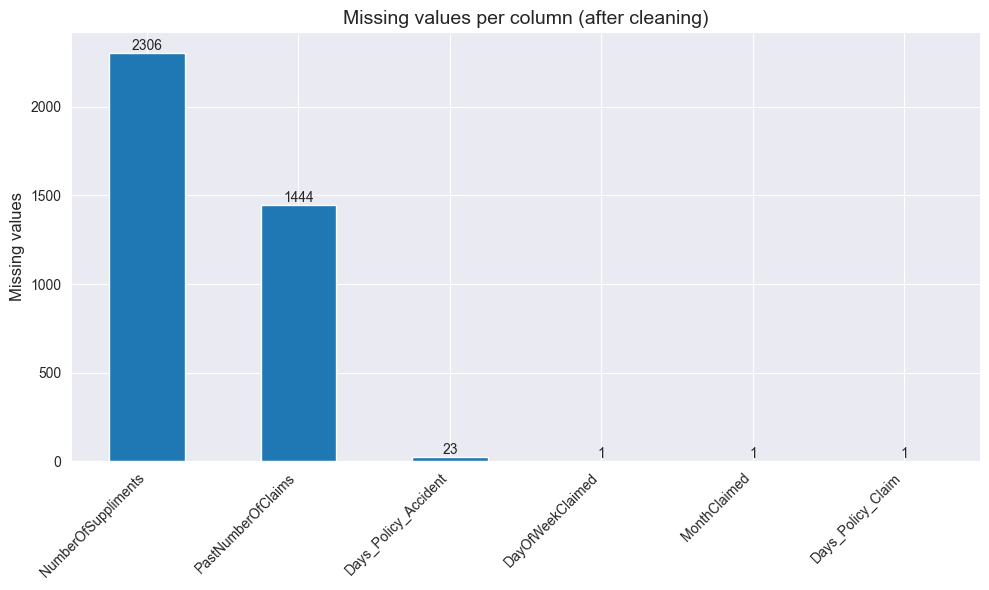

In [6]:
missing_tokens = {"0", "none", "None", "NONE", "NA", "N/A", ""}    # Set of missing tokens.

cat_cols = df.select_dtypes(include = ["object"]).columns.tolist() # Select columns of type object.
for c in cat_cols:                                                 
    df[c] = df[c].astype(str).str.strip()                          # Remove leading and trailing whitespace.
    df[c] = df[c].replace({v: np.nan for v in missing_tokens})     # Replace missing tokens with NaN.

# Check for missing values after cleaning.
na = df.isna().sum()
na = na[na > 0].sort_values(ascending = False)
ax = na.plot(kind = "bar", figsize = (10,6))
ax.set_ylabel("Missing values", fontsize = 12)
ax.set_title("Missing values per column (after cleaning)", fontsize = 14)
plt.xticks(rotation = 45, ha = "right")
plt.tight_layout()
for i, v in enumerate(na):
    ax.text(i, v + 0.5, str(v), ha = 'center', va = 'bottom', fontsize = 10)
print((na / len(df) * 100).round(2))
plt.show()

## **1.2. Standardizing and Normalizing Categorical Variables**

>Typographical errors and inconsistencies were identified in the `Make` column (e.g., `"Accura"`, `"VW"`, `"Nisson"`, `"Porche"`, `"Mecedes"`). These values were replaced with their correct standardized forms to ensure consistency in the categorical data.
>
>In the `PolicyType` column, inconsistent spacing around hyphens was normalized using a regular expression, replacing any variation of spaces before and after the hyphen with a single space on each side `(\s+-\s+)`. This prevents duplicate categories caused solely by formatting differences.
>
>After applying these transformations, the unique categories of both columns were rechecked to confirm that no unexpected categories were introduced and that all previously inconsistent values were standardized.

In [7]:
# Correct common typos and inconsistencies in car makes.
make_map = { # Dictionary to map incorrect car makes to correct ones.
    "Accura"  : "Acura",
    "VW"      : "Volkswagen",
    "Nisson"  : "Nissan",
    "Porche"  : "Porsche",
    "Mecedes" : "Mercedes"
}
df["Make"] = df["Make"].replace(make_map) # Replace according to the make_map.

# PolicyType: normalize spacing around hyphens to ensure consistent formatting.
df["PolicyType"] = df["PolicyType"].str.replace(r"\s+-\s+", " - ", regex = True)

# Validation step.
print(df["Make"].unique())
print(df["PolicyType"].unique())

['Honda' 'Chevrolet' 'Pontiac' 'Toyota' 'Mazda' 'Ford' 'Acura' 'Mercury'
 'Volkswagen' 'Saturn' 'Dodge' 'Saab' 'BMW' 'Nissan' 'Porsche' 'Ferrari'
 'Jaguar' 'Mercedes']
['Sedan - All Perils' 'Sedan - Collision' 'Sedan - Liability'
 'Sport - Collision' 'Utility - All Perils' 'Utility - Collision'
 'Utility - Liability' 'Sport - All Perils' 'Sport - Liability']


## **1.3. Casting Nominal Variables to category**

>Nominal variables (e.g., `AccidentArea`, `VehicleCategory`, `Sex`, `MaritalStatus`, `Fault`, `PoliceReportFiled`, `WitnessPresent`, `AgentType`, `BasePolicy`, `PolicyType`, `Make`) were cast to the pandas category `dtype`. 
>
>This change:
>- Reduces memory usage by storing integer codes instead of full strings.
>- Stabilizes category vocabularies, ensuring that only known categories are kept.
>- Prevents accidental category creation when new values with typos or formatting inconsistencies are introduced.
>
>After conversion, memory usage dropped significantly (e.g., `Make` and `PolicyType` together now occupy only `10.9 KB`), highlighting the efficiency of the category dtype for storing nominal variables.

In [8]:
for col in [
    "AccidentArea", "VehicleCategory", "Sex", "MaritalStatus", "Fault", "PoliceReportFiled",
    "WitnessPresent", "AgentType", "BasePolicy", "PolicyType", "Make"
    ]: # Nominal columns.
    if col in df.columns:
        df[col] = df[col].astype("category") # Convert to category dtype.

# Optional validation.
print(df[["Make", "PolicyType"]].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Make        5000 non-null   category
 1   PolicyType  5000 non-null   category
dtypes: category(2)
memory usage: 10.9 KB
None


## **1.4. Applying Logical Orders to Nominal Variables (Calendar and Weeks)**

>Variables with a natural logical sequence but not true ordinality, namely `Month`, `MonthClaimed`, `DayOfWeek`, `DayOfWeekClaimed`, `WeekOfMonth`, and `WeekOfMonthClaimed`, were converted to ordered categorical types using predefined calendars (`Jan to Dec`; `Mon to Sun`; `weeks 1 to 5`).
>
>This step ensures consistent sorting, meaningful plotting, and proper comparisons without mistakenly treating them as numeric variables. Out-of-vocabulary values (e.g., `"0"` in `MonthClaimed` or `DayOfWeekClaimed`) were automatically set to `NaN` during the conversion.
>
>After ordering, MonthClaimed and DayOfWeekClaimed each had 1 missing value (0.02 % of the dataset), consistent with the invalid tokens detected earlier.

In [9]:
# Months: enforce consistent spelling and chronological order.
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for col in ["Month", "MonthClaimed"]:                                           
    df[col] = pd.Categorical(df[col], categories = month_order, ordered = True) # Convert to an ordered categorical type using the defined month order.

# Days of the week: enforce consistent spelling and chronological order.
dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for col in ["DayOfWeek","DayOfWeekClaimed"]:
    df[col] = pd.Categorical(df[col], categories = dow_order, ordered = True) # Convert to an ordered categorical type using the defined day order.

# Weeks of month (1–5).
week_order = [1, 2, 3, 4, 5]
df["WeekOfMonth"] = pd.Categorical(df["WeekOfMonth"], categories = week_order, ordered = True)
df["WeekOfMonthClaimed"] = pd.Categorical(df["WeekOfMonthClaimed"], categories = week_order, ordered = True)

# Check how many NaNs were introduced due to invalid tokens.
print(df[["MonthClaimed", "DayOfWeekClaimed"]].isna().sum())

MonthClaimed        1
DayOfWeekClaimed    1
dtype: int64


## **1.5. Standardizing Ordinal Categorical Variables**

>Truly ordinal variables were converted to ordered categorical types with explicit progressions that reflect their inherent magnitude:
>- **VehiclePrice:** lowest to highest price ranges.
>- **Days_Policy_Accident** and **Days_Policy_Claim:** from “none” to “more than 30”.
>- **PastNumberOfClaims:** from “none” to “more than 4”.
>- **AgeOfVehicle:** from “new” to “more than 7”.
>- **AgeOfPolicyHolder:** from youngest (“16 to 17”) to oldest (“over 65”).
>- **NumberOfSuppliments:** from “none” to “more than 5”.
>- **AddressChange_Claim:** from “under 6 months” to “no change”.
>- **NumberOfCars:** from “1 vehicle” to “5 to 8”.
>
>This transformation ensures that statistical models and visualizations interpret these variables according to their inherent ranking, avoiding incorrect assumptions from treating them as unordered labels.
>
>As in **1.4**, any value not listed in the specified order is set to `NaN`, which is consistent with the cleaning process in **1.1**.

In [10]:
# VehiclePrice.
price_order = ["less than 20000", "20000 to 29000", "30000 to 39000",
               "40000 to 59000", "60000 to 69000", "more than 69000"]
df["VehiclePrice"] = pd.Categorical(df["VehiclePrice"], categories = price_order, ordered = True)

# Days policy span.
policy_span_order = ["none", "1 to 7", "8 to 15", "15 to 30", "more than 30"]
for c in ["Days_Policy_Accident", "Days_Policy_Claim"]:
    df[c] = pd.Categorical(df[c], categories = policy_span_order, ordered = True)

# PastNumberOfClaims.
past_claims_order = ["none", "1", "2 to 4", "more than 4"]
df["PastNumberOfClaims"] = pd.Categorical(df["PastNumberOfClaims"], categories = past_claims_order, ordered = True)

# AgeOfVehicle.
age_vehicle_order = ["new", "2 years", "3 years", "4 years", "5 years",
                     "6 years", "7 years", "more than 7"]
df["AgeOfVehicle"] = pd.Categorical(df["AgeOfVehicle"], categories = age_vehicle_order, ordered = True)

# AgeOfPolicyHolder.
age_holder_order = ["16 to 17", "18 to 20", "21 to 25", "26 to 30", "31 to 35",
                    "36 to 40", "41 to 50", "51 to 65", "over 65"]
df["AgeOfPolicyHolder"] = pd.Categorical(df["AgeOfPolicyHolder"], categories = age_holder_order, ordered = True)

# NumberOfSuppliments.
suppl_order = ["none", "1 to 2", "3 to 5", "more than 5"]
df["NumberOfSuppliments"] = pd.Categorical(df["NumberOfSuppliments"], categories = suppl_order, ordered = True)

# AddressChange_Claim.
addr_change_order = ["under 6 months", "1 year", "2 to 3 years", "4 to 8 years", "no change"]
df["AddressChange_Claim"] = pd.Categorical(df["AddressChange_Claim"], categories = addr_change_order, ordered = True)

# NumberOfCars.
cars_order = ["1 vehicle", "2 vehicles", "3 to 4", "5 to 8"]
df["NumberOfCars"] = pd.Categorical(df["NumberOfCars"], categories = cars_order, ordered = True)

## **1.6. Plotting Copy and Label Simplification**

>A dedicated copy of the dataset (`df_plot` = `df.copy()`) was created exclusively for visualization purposes, following best practices to avoid modifying the preprocessed source (`df`). In this copy, some categorical labels were shortened (e.g., `"1 vehicle"` to `"1"`) to improve plot readability. The order of categories was explicitly preserved to ensure visualizations respect the same logical ranking defined in **1.5**.

In [11]:
df_plot = df.copy() # Create a copy for plotting.

df_plot["NumberOfCars"] = df_plot["NumberOfCars"].cat.rename_categories( # Rename categories safely for plotting labels (keeps order).
    {
        "1 vehicle"  : "1",
        "2 vehicles" : "2",
        "3 to 4"     : "3 to 4",
        "5 to 8"     : "5 to 8"
        }
    ).cat.reorder_categories(["1","2","3 to 4","5 to 8"], ordered = True)

## **1.7. Post-Cleaning Validation of Categorical Values**

>After all standardization and ordering steps (`Sections 1.1 – 1.6`), a validation step was performed to ensure that each categorical column contains only values from its predefined vocabulary.
>
>This acts as a final integrity check to confirm that no unexpected values remain, which could otherwise lead to issues in downstream encoding or analysis. If discrepancies are found, the offending values are listed; otherwise, the output explicitly states that no unexpected values were found for each column.
>
>**Validation output:** All categorical variables passed the integrity check, no unexpected values were found in any column. This confirms that the preprocessing pipeline has successfully standardized and ordered all categorical data according to the predefined vocabularies.

In [12]:
# Dictionary mapping each column to its allowed categories.
allowed_values = {
    "Month"                : ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    "MonthClaimed"         : ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    "DayOfWeek"            : ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    "DayOfWeekClaimed"     : ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    "WeekOfMonth"          : [1, 2, 3, 4, 5],
    "WeekOfMonthClaimed"   : [1, 2, 3, 4, 5],
    "VehiclePrice"         : ["less than 20000", "20000 to 29000", "30000 to 39000",
                              "40000 to 59000", "60000 to 69000", "more than 69000"],
    "Days_Policy_Accident" : ["none", "1 to 7", "8 to 15", "15 to 30", "more than 30"],
    "Days_Policy_Claim"    : ["none", "1 to 7", "8 to 15", "15 to 30", "more than 30"],
    "PastNumberOfClaims"   : ["none", "1", "2 to 4", "more than 4"],
    "AgeOfVehicle"         : ["new", "2 years", "3 years", "4 years", "5 years", "6 years",
                              "7 years", "more than 7"],
    "AgeOfPolicyHolder"    : ["16 to 17", "18 to 20", "21 to 25", "26 to 30", "31 to 35",
                              "36 to 40", "41 to 50", "51 to 65", "over 65"],
    "NumberOfSuppliments"  : ["none", "1 to 2", "3 to 5", "more than 5"],
    "AddressChange_Claim"  : ["under 6 months", "1 year", "2 to 3 years", "4 to 8 years", "no change"],
    "NumberOfCars"         : ["1 vehicle", "2 vehicles", "3 to 4", "5 to 8"]
}

def unexpected_vals(series: pd.Series, allowed: list[str]) -> list[str]:
    """
    Returns a sorted list of unexpected values in a Pandas Series.
    
    Parameters
    ----------
    series : pd.Series
        Series to check.
    allowed : list[str]
        The list of allowed values.

    Returns
    -------
    list[str]
        Unexpected values found in the series (empty if none).
    """
    current_values = set(series.dropna().unique())
    return sorted(current_values - set(allowed))

# Loop over each column and check for unexpected values.
for col, allowed in allowed_values.items():
    if col in df.columns:
        extras = unexpected_vals(df[col], allowed)
        if extras:
            print(f"{col:<21} has unexpected values: {extras}.")
        else:
            print(f"{col:<21}: no unexpected values.")

Month                : no unexpected values.
MonthClaimed         : no unexpected values.
DayOfWeek            : no unexpected values.
DayOfWeekClaimed     : no unexpected values.
WeekOfMonth          : no unexpected values.
WeekOfMonthClaimed   : no unexpected values.
VehiclePrice         : no unexpected values.
Days_Policy_Accident : no unexpected values.
Days_Policy_Claim    : no unexpected values.
PastNumberOfClaims   : no unexpected values.
AgeOfVehicle         : no unexpected values.
AgeOfPolicyHolder    : no unexpected values.
NumberOfSuppliments  : no unexpected values.
AddressChange_Claim  : no unexpected values.
NumberOfCars         : no unexpected values.


## **1.8. Duplicate Detection and Resolution**

>The dataset was checked for both exact duplicate rows and duplicated `IDs`. No duplicates were found in either case, confirming that each record is unique in both content and identifier, so, no duplicate data processing was necessary. The code includes safeguards to remove exact duplicates if detected and to flag non-unique `IDs` for inspection, with an optional assertion to enforce uniqueness.

In [13]:
# Count exact duplicate rows and duplicated IDs.
dup_any = df.duplicated().sum()       # Count of all duplicated rows.
dup_id  = df["ID"].duplicated().sum() # Count of duplicated IDs.
print(f"Exact duplicates: {dup_any} | Duplicated IDs: {dup_id}")

# Remove exact duplicate rows (if any).
if dup_any > 0:
    before = len(df)
    df = df.drop_duplicates().copy()
    removed = before - len(df)
    print(f"Removed {removed} exact duplicate rows.")              

# Report duplicated IDs (if any).
if dup_id > 0:
    dup_ids = df.loc[df["ID"].duplicated(keep = False), "ID"]
    print("Sample duplicated IDs:")
    print(dup_ids.head(10).to_list())
    display(df[df["ID"].isin(dup_ids.unique())].sort_values("ID")) # Inspect duplicated rows.

# Optional hard check (enable only if ID must be unique in your problem)
assert df["ID"].is_unique, "ID must be unique after cleaning."

Exact duplicates: 0 | Duplicated IDs: 0


## **1.9. Missingness Summary (Post‑cleaning Sanity Check)**

>After completing all preprocessing steps, a final missing value audit was performed across the entire dataset (all dtypes). This ensures that no unexpected nulls were introduced during transformations and confirms the scale of any remaining missingness before modeling.
>
>The summary table below reports both the count and percentage of missing entries per column, sorted in descending order by missing count.
>
>The results show that missingness is concentrated in:
>- `NumberOfSuppliments` (`46.12%`) and `PastNumberOfClaims` (`28.88%`), both categorical ordinal variables.
>- Minor missingness (`<0.5%`) in `Days_Policy_Accident`, `DayOfWeekClaimed`, `MonthClaimed`, and `Days_Policy_Claim`.
>
>High-missingness variables may require imputation strategies or be excluded depending on the modeling approach.

In [14]:
# Count and percentage of missing values post-cleaning.
na_counts = df.isna().sum()                                         # Counts per column.
na_counts = na_counts[na_counts > 0].sort_values(ascending = False) # Keep only columns with missing values.          
na_pct = (na_counts / len(df) * 100).round(2)                       # Percentages relative to the current DataFrame size.

# Build concise summary table.
na_report = pd.DataFrame({
    "missing_count" : na_counts,
    "missing_pct"   : na_pct
    })

print(na_report)

                      missing_count  missing_pct
NumberOfSuppliments            2306        46.12
PastNumberOfClaims             1444        28.88
Days_Policy_Accident             23         0.46
DayOfWeekClaimed                  1         0.02
MonthClaimed                      1         0.02
Days_Policy_Claim                 1         0.02


## **1.10. High Cardinality and Rare Level Detection**

For each categorical variable in the dataset, the code: 
1. Identifies columns with **high cardinality**, defined as having a large number of unique non-null values relative to the dataset size.  
2. Detects **rare categories**, defined as levels whose relative frequency is below `1%` or whose absolute count is less than `20`.  
3. Outputs two reports:  
   - **High cardinality summary**: columns with the count of unique non-null levels.  
   - **Rare level report**: a breakdown per column showing each rare category, its absolute frequency, and its relative percentage.  
4. Generates a **rare levels summary** counting how many rare categories exist in each variable.  

No modifications are applied to the DataFrame at this stage; the results are for diagnostic purposes to guide potential category grouping or exclusion in later preprocessing steps.

**Mini-conclusion:**  
In this dataset:  
- **High cardinality:** `ID` contains `5000` unique values (one per record), providing no predictive value and making it a candidate for removal in modeling.  
- **Rare categories:** Multiple variables contain levels with very low frequency, such as `Ferrari` in **Make** (1 record), `"under 6 months"` in **AddressChange_Claim** (1 record), and `"Sunday"` in **DayOfWeekClaimed** (20 records).  
- These rare categories may cause instability in `WoE/IV` transformations and statistical models, and should be considered for grouping into an `"Other"` bucket or merging with similar categories before training.

In [15]:
HIGH_CARD_THRESHOLD = 100  # Columns with > this many distinct non-null levels are flagged.
RARE_MIN_PCT        = 0.01 # Categories with <1% share are considered rare.
RARE_MIN_COUNT      = 20   # ...or with fewer than 20 rows (use OR with pct).

# Select categorical columns (object or category).
cat_cols = [
    c for c in df.columns
    if isinstance(df[c].dtype, CategoricalDtype) or df[c].dtype == "object"
]
# High cardinality report.
cardinality = (
    pd.Series({c: df[c].nunique(dropna = True) for c in cat_cols})
      .sort_values(ascending = False)
      .rename("n_unique")
    .to_frame()
)
high_card = cardinality[cardinality["n_unique"] > HIGH_CARD_THRESHOLD]

print("-" * 50 + "\nHigh cardinality (non-null unique levels)\n" + "-" * 50)
if high_card.empty:
    print("None flagged (OK).")
else:
    print(high_card)

--------------------------------------------------
High cardinality (non-null unique levels)
--------------------------------------------------
    n_unique
ID      5000


In [16]:
# Rare category report (per column).
def rare_levels_for(col: str) -> pd.DataFrame:
    """
    Identify rare categories in a categorical column.

    Parameters
    ----------
    col : str
        The name of the categorical column to analyze.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the rare categories and their counts/percentages.
    """
    vc        = df[col].value_counts(dropna = True)                                          # Value counts (non-null).        
    pct       = (vc / len(df)).rename("percentage")                                          # Percentage of total.
    rep       = pd.concat([vc.rename("count"), pct], axis = 1)                               # Combine counts and percentages.
    rare_mask = (rep["percentage"] < RARE_MIN_PCT) | (rep["count"] < RARE_MIN_COUNT)         # Identify rare categories.
    rare      = rep[rare_mask].sort_values(["percentage","count"], ascending = [True, True]) # Sort by percentage and count.

    return rare

# Dictionary to hold rare category reports.
rare_report = {}
for c in cat_cols:
    rr = rare_levels_for(c)
    if not rr.empty:
        rare_report[c] = rr

# Print rare category levels.
print("-" * 60 + "\nRare category levels per column (pct < "f"{RARE_MIN_PCT:.2%} OR count < {RARE_MIN_COUNT})\n" + "-" * 60)
if not rare_report: # No rare categories found.
    print("None flagged")
else:               # Rare categories found.
    for c, rr in rare_report.items():
        print(f"\n[{c}]")
        print(rr)

------------------------------------------------------------
Rare category levels per column (pct < 1.00% OR count < 20)
------------------------------------------------------------

[ID]
            count  percentage
ID                           
CL00007646      1      0.0002
CL00011494      1      0.0002
CL00006844      1      0.0002
CL00009339      1      0.0002
CL00000026      1      0.0002
...           ...         ...
CL00005074      1      0.0002
CL00007053      1      0.0002
CL00004494      1      0.0002
CL00009324      1      0.0002
CL00003330      1      0.0002

[5000 rows x 2 columns]

[Make]
          count  percentage
Make                       
Ferrari       1      0.0002
Porsche       1      0.0002
Mercedes      1      0.0002
Jaguar        2      0.0004
BMW           6      0.0012
Nissan       12      0.0024
Saturn       21      0.0042
Saab         33      0.0066
Dodge        33      0.0066
Mercury      38      0.0076

[DayOfWeekClaimed]
                  count  percenta

In [17]:
# Quick summary table: number of rare levels per column.
if rare_report:
    rare_summary = pd.DataFrame(
        {
            "n_rare_levels": {c: len(rr) for c, rr in rare_report.items()}
        }
    ).sort_values("n_rare_levels", ascending = False)
    print("-" * 40 + "\nRare levels summary\n" + "-" * 40)
    print(rare_summary)

----------------------------------------
Rare levels summary
----------------------------------------
                      n_rare_levels
ID                             5000
Make                             10
PolicyType                        4
Days_Policy_Accident              4
Days_Policy_Claim                 4
DayOfWeekClaimed                  2
MaritalStatus                     2
AgeOfVehicle                      2
AgeOfPolicyHolder                 2
VehiclePrice                      1
PastNumberOfClaims                1
WitnessPresent                    1
NumberOfSuppliments               1
AddressChange_Claim               1
NumberOfCars                      1


In [18]:
print_uniques(df)  # Final check for unique values in each column.

- ID: ['CL00007646' 'CL00009711' 'CL00010809' ... 'CL00007097' 'CL00002875'
 'CL00003330']
- Month: ['Aug', 'Dec', 'Feb', 'Jun', 'Jan', ..., 'May', 'Oct', 'Sep', 'Mar', 'Apr']
Length: 12
Categories (12, object): ['Jan' < 'Feb' < 'Mar' < 'Apr' ... 'Sep' < 'Oct' < 'Nov' < 'Dec']
- WeekOfMonth: [4, 2, 3, 1, 5]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]
- DayOfWeek: ['Friday', 'Tuesday', 'Sunday', 'Monday', 'Thursday', 'Wednesday', 'Saturday']
Categories (7, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday' < 'Saturday' < 'Sunday']
- Make: ['Honda', 'Chevrolet', 'Pontiac', 'Toyota', 'Mazda', ..., 'Nissan', 'Porsche', 'Ferrari', 'Jaguar', 'Mercedes']
Length: 18
Categories (18, object): ['Acura', 'BMW', 'Chevrolet', 'Dodge', ..., 'Saab', 'Saturn', 'Toyota', 'Volkswagen']
- AccidentArea: ['Urban', 'Rural']
Categories (2, object): ['Rural', 'Urban']
- DayOfWeekClaimed: ['Monday', 'Wednesday', 'Thursday', 'Tuesday', 'Friday', 'Saturday', 'Sunday', NaN]
Categories (7, object):

# **2. Exploratory Data Analysis**

## **2.1. Fraud vs Non-Fraud Cases**

>A bar chart was created to compare fraud (`1`) and non-fraud (`0`) cases. Counts and percentages were displayed above each bar for clarity. The chart reveals a significant class imbalance:
>- Non-Fraud (`0`): $4,708$ cases ($94.16\%$).
>- Fraud (`1`): $292$ cases ($5.84\%$).
>
>This indicates that fraud is a rare event, which means any predictive model must:
>- Use metrics that account for imbalance, such as `AUC-PR`, `recall`, and `precision` for the positive class.
>- We have to consider techniques like stratified splitting for train/test, resampling (SMOTE, undersampling), or class weight adjustment in the model.

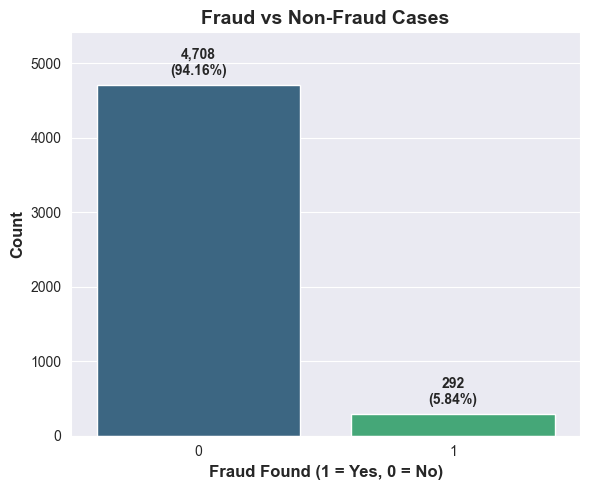

In [19]:
fraud_counts = df_plot['FraudFound_P'].value_counts() # Count of fraud cases.
fraud_perc = fraud_counts / len(df_plot) * 100        # Percentage of fraud cases.

plt.figure(figsize = (6,5))
ax = sns.barplot(
    x = fraud_counts.index, y = fraud_counts.values, hue = fraud_counts.index, 
    dodge = False, palette = 'viridis', legend = False
)
plt.title('Fraud vs Non-Fraud Cases', fontsize = 14, fontweight = 'bold')
plt.xlabel('Fraud Found (1 = Yes, 0 = No)', fontsize = 12, fontweight = 'bold')
plt.ylabel('Count', fontsize = 12, fontweight = 'bold')
for i, v in enumerate(fraud_counts.values):
    ax.text(i, v + (0.02 * max(fraud_counts.values)), 
            f"{v:,}\n({fraud_perc.values[i]:.2f}%)", 
            ha = 'center', va = 'bottom', fontsize = 10, fontweight = 'bold')
ax.set_ylim(0, max(fraud_counts.values) * 1.15)
plt.tight_layout()
plt.show()

## **2.2. Distribution of Categorical Variables**

>A total of **26 categorical variables** were analyzed, excluding the `ID` column.  
>The bar charts reveal the following patterns:  
>
>- **Month** and **DayOfWeek** show relatively balanced distributions. However, in `DayOfWeekClaimed` most claims occur on weekdays, with significantly fewer on Saturday and Sunday.  
>- **WeekOfMonth** is relatively balanced, but not all months have a fifth week, explaining the naturally lower counts for week 5 in both `WeekOfMonth` and `WeekOfMonthClaimed`.  
>- In `Make`, **Pontiac** dominates the dataset, while brands such as **Porsche**, **Ferrari**, **BMW**, and **Saturn** are rare.  
>- `AccidentArea` shows a strong skew toward `Urban` claims.  
>- In `Sex`, **Male** policyholders greatly outnumber **Female**.  
>- `VehicleCategory` is dominated by **Sedan** vehicles, with fewer **Sport** and even fewer **Utility** vehicles.  
>- `AgeOfVehicle` peaks at **7 years**, and `AgeOfPolicyHolder` is dominated by the **31–35** range.  
>- `PoliceReportFiled` is overwhelmingly “No”, with very few “Yes” cases.  
>- `WitnessPresent` is also overwhelmingly “No”.  
>- `AgentType` is heavily skewed toward **External** agents.  
>- In `NumberOfSuppliments`, the most frequent value is “more than 5”.  
>- `AddressChange_Claim` is dominated by “no change”.  
>- `NumberOfCars` is overwhelmingly “1 vehicle”.  
>- `BasePolicy` is more evenly distributed, though **Collision** is slightly more common than the other types.  
>
>While high imbalance in some variables is not inherently problematic, it may impact the model's ability to learn from underrepresented categories. These imbalances will be re-evaluated in **Section 2.4** to determine their relationship with `FraudFound_P` and guide decisions such as rare category grouping.  
>
>**Note:** The count of 26 plots corresponds to all categorical variables in the dataset after excluding the `ID` column.

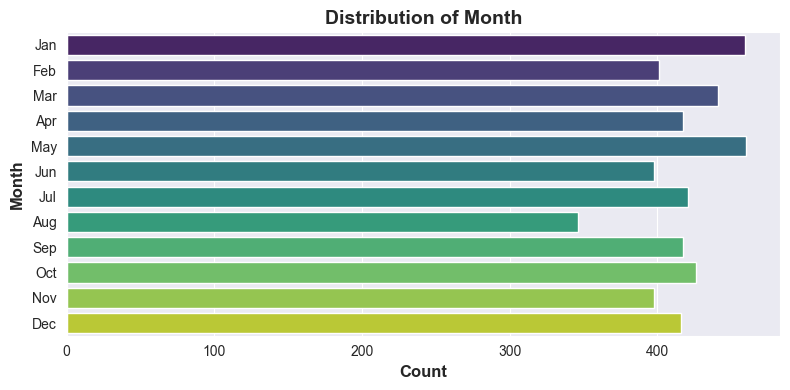

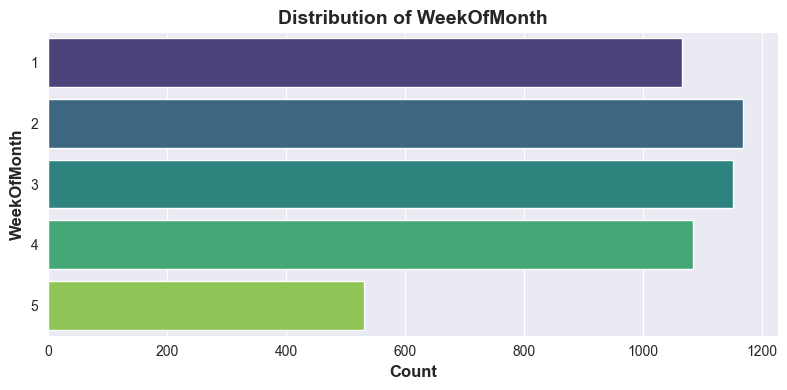

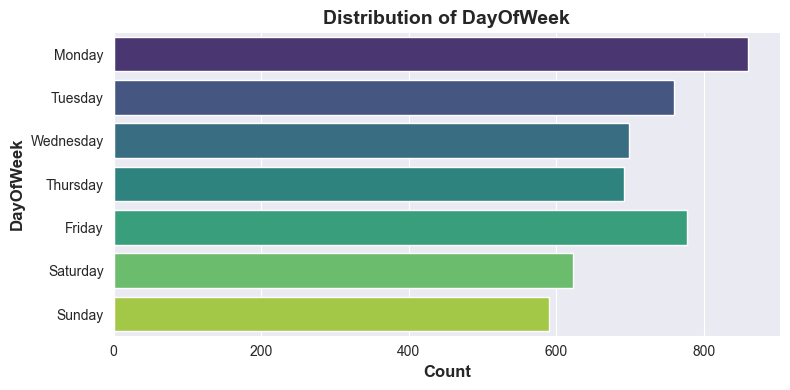

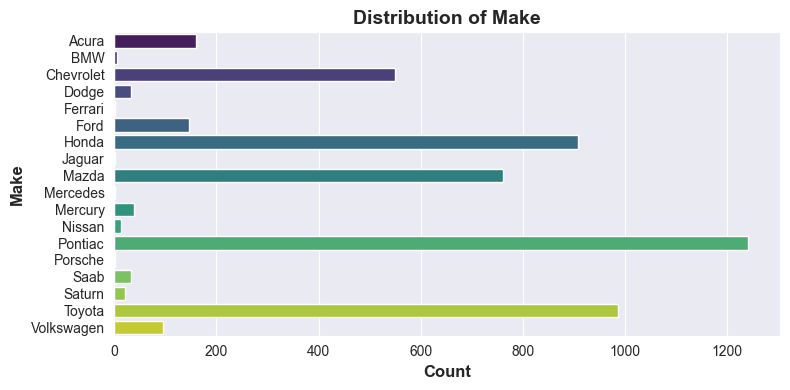

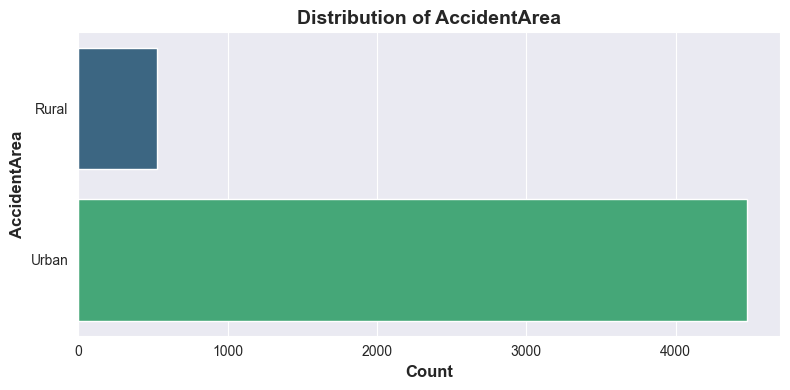

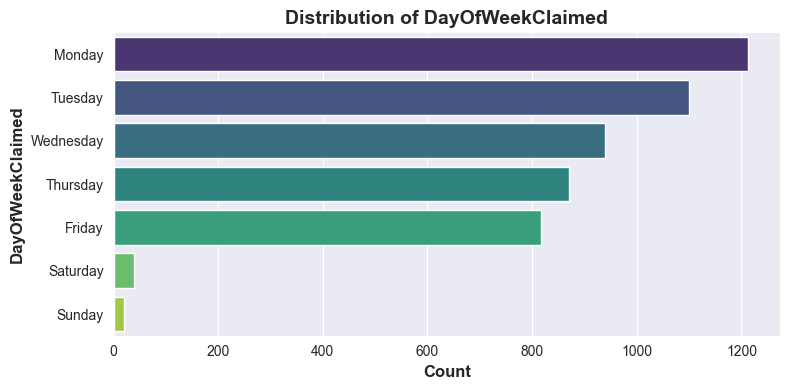

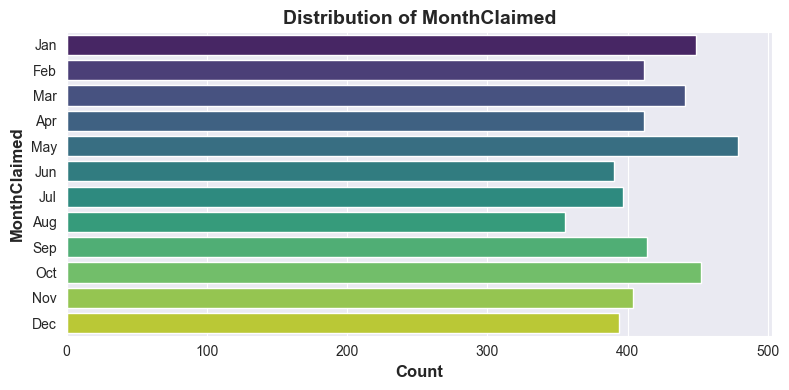

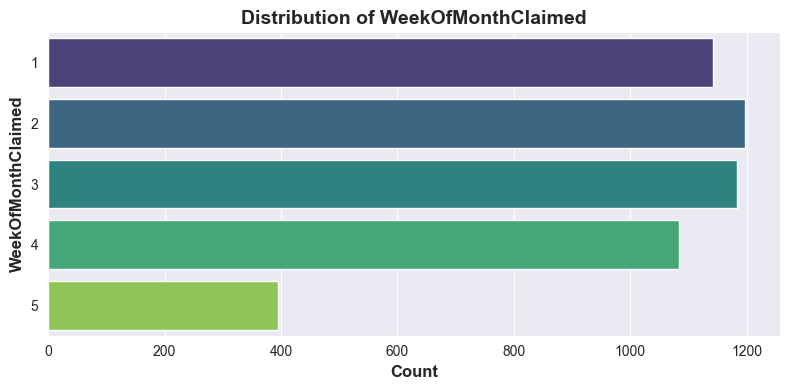

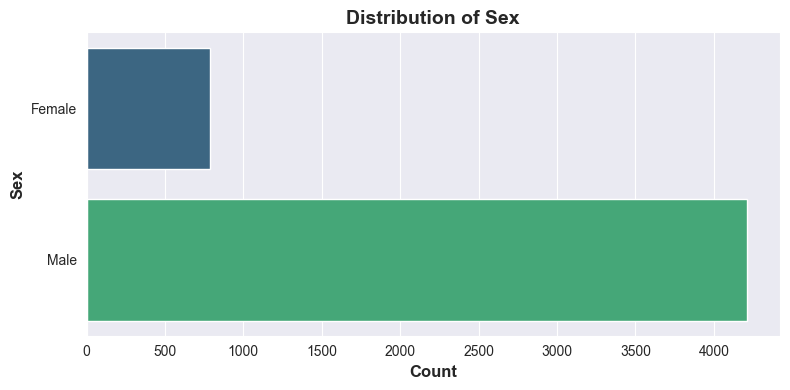

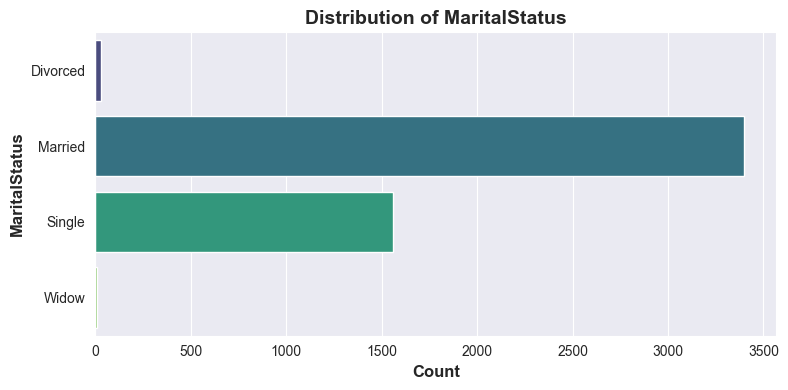

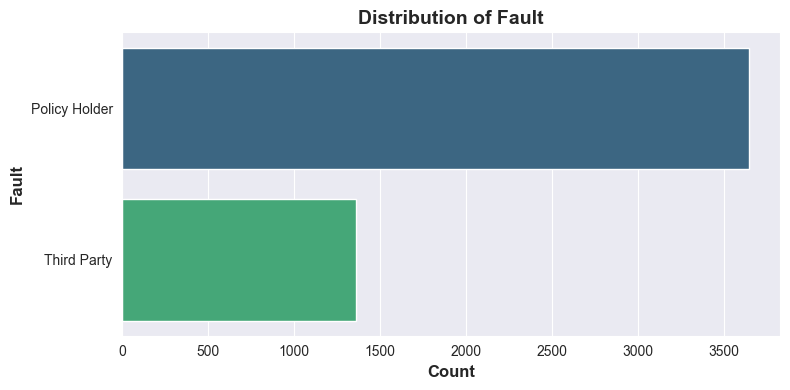

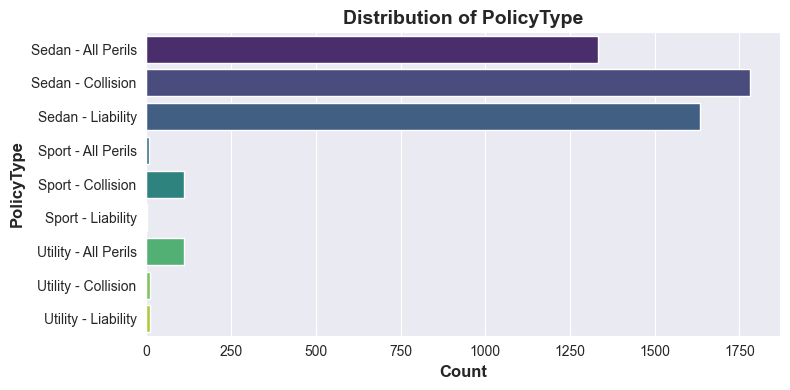

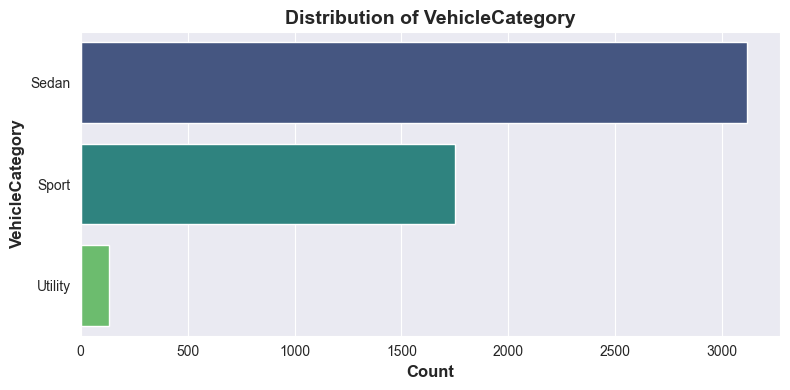

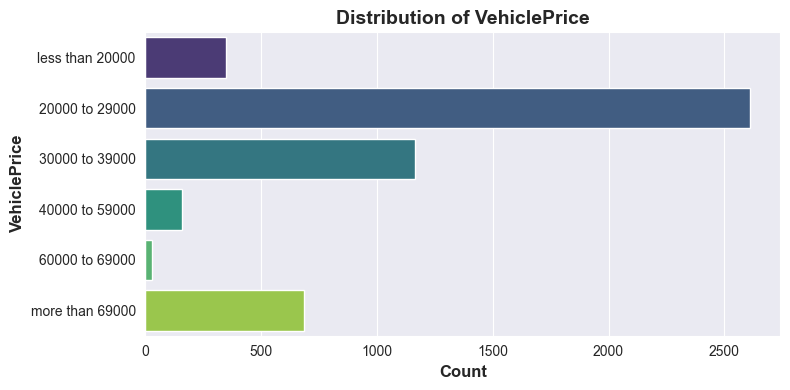

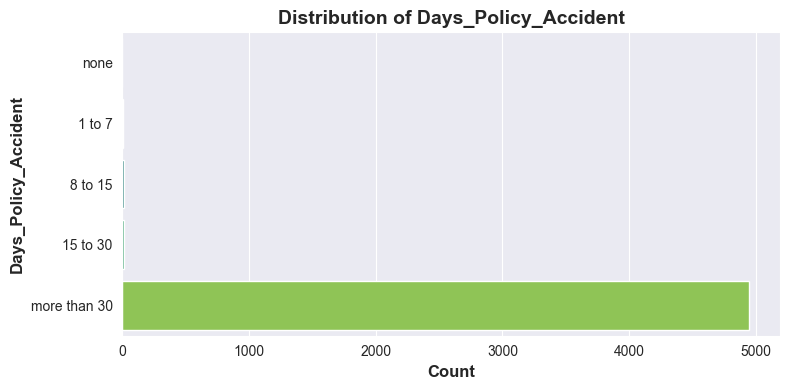

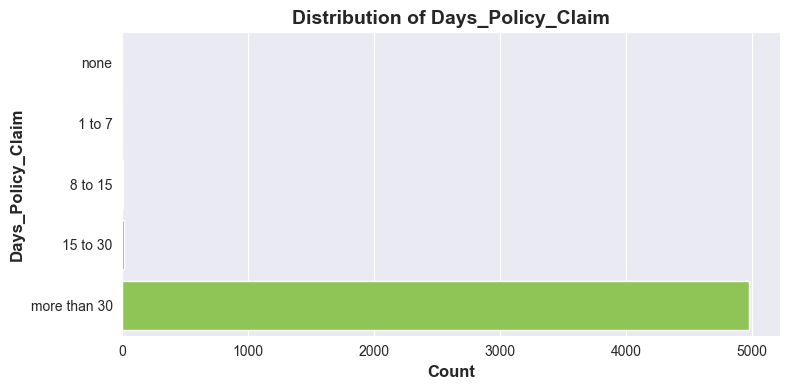

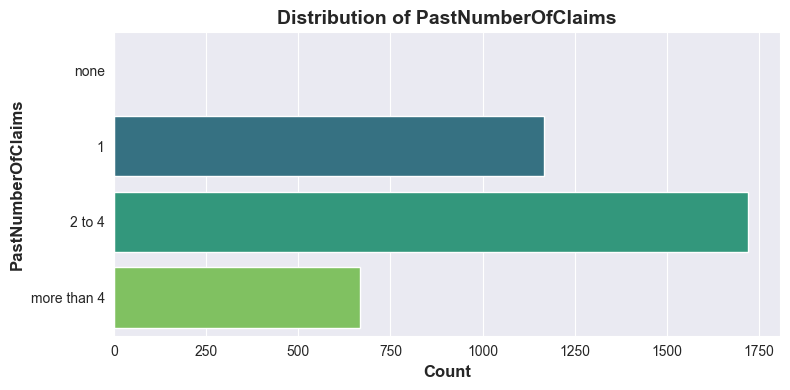

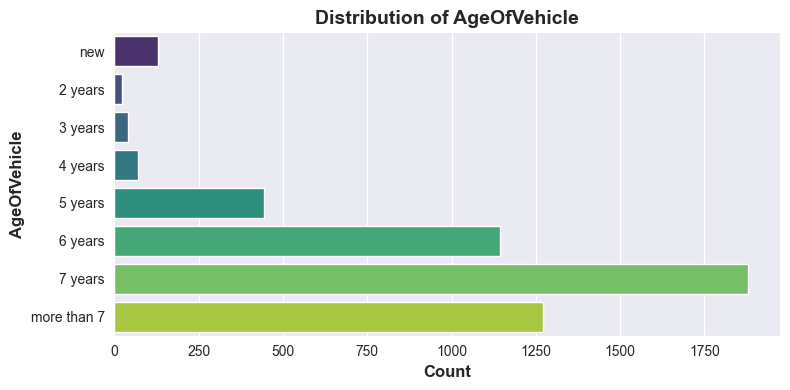

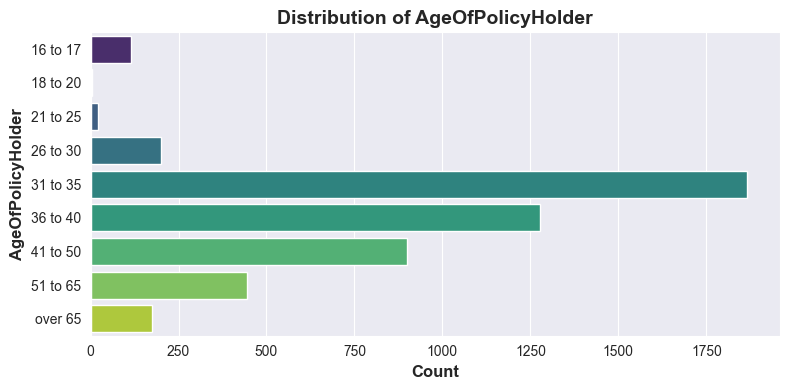

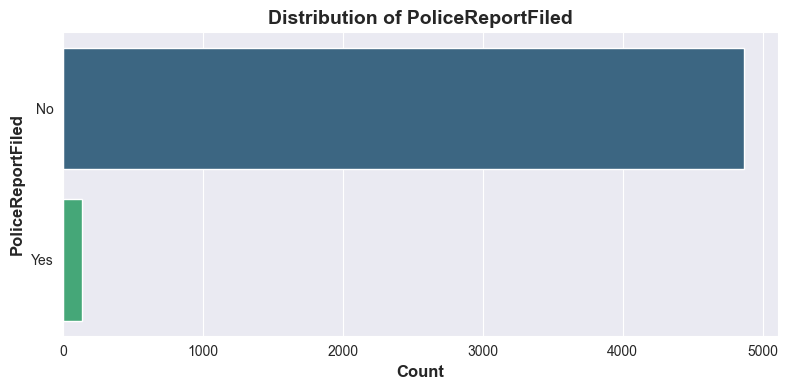

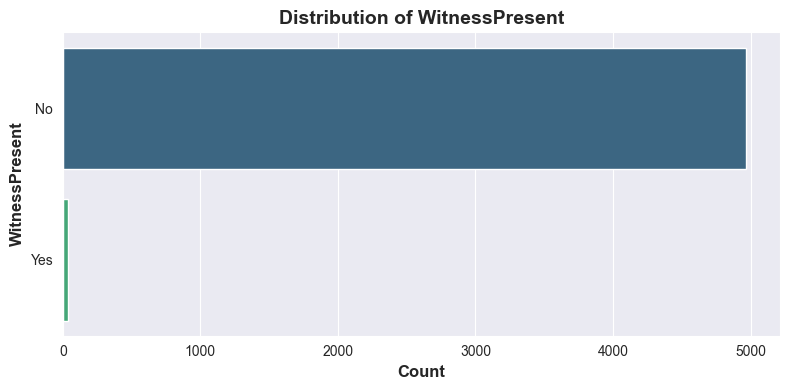

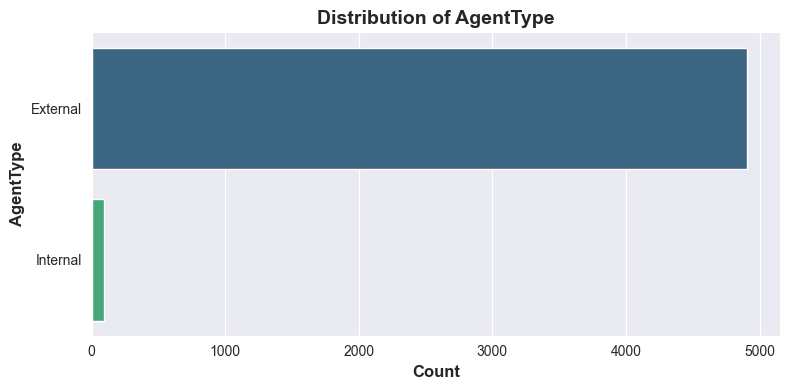

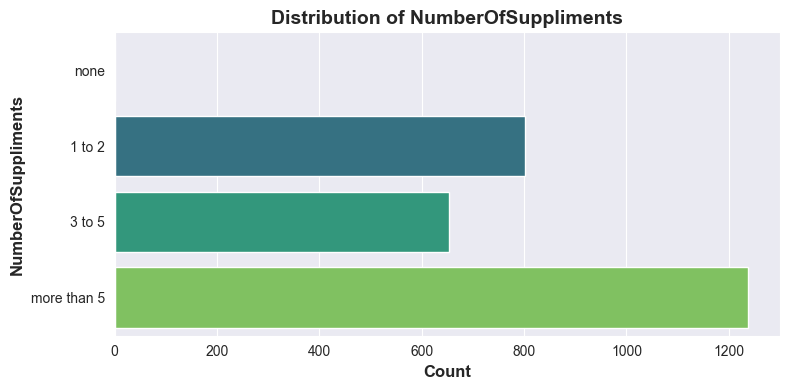

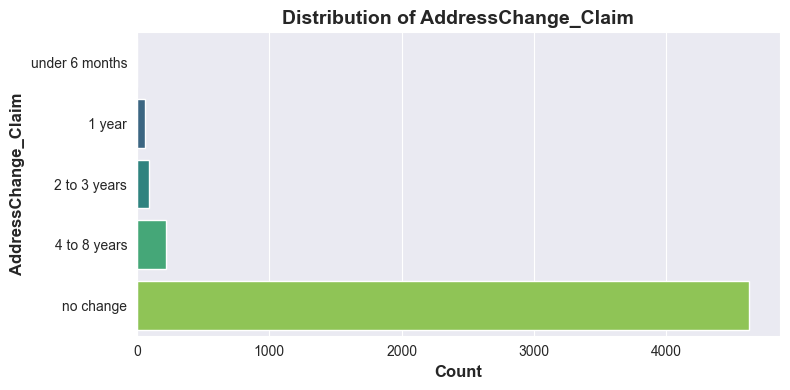

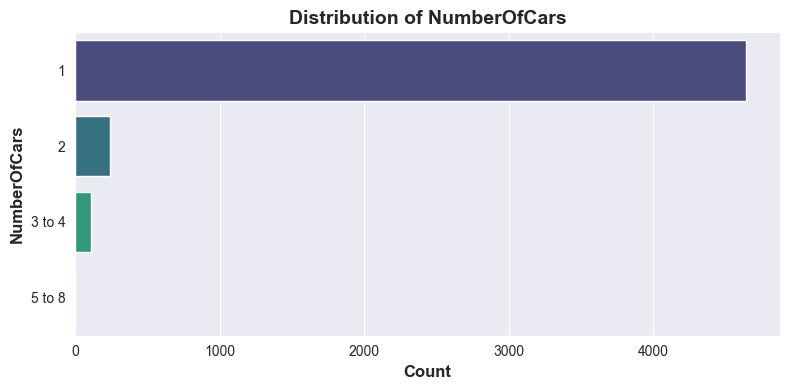

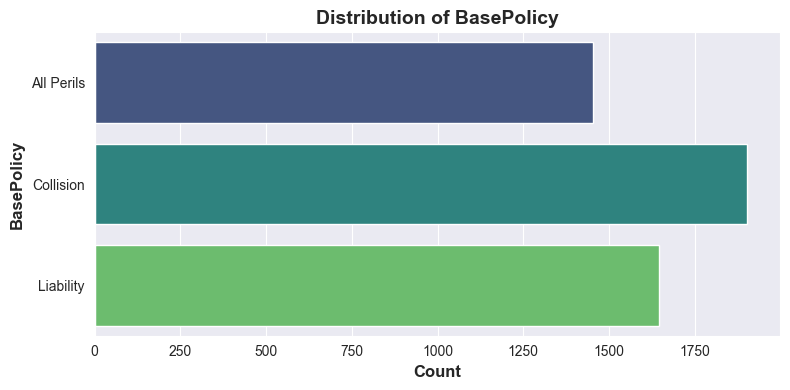

In [20]:
categorical_cols = df_plot.select_dtypes(include = ['category', 'object']).columns.drop(['ID'])

# Plot distribution of each categorical variable.
for col in categorical_cols:
    plt.figure(figsize = (8,4))
    order = df_plot[col].value_counts().index
    sns.barplot(y = order, x = df_plot[col].value_counts()[order].values, palette = 'viridis', hue = order, dodge = False, legend = False)
    plt.title(f'Distribution of {col}', fontsize = 14, fontweight = 'bold')
    plt.xlabel('Count', fontsize = 12, fontweight = 'bold')
    plt.ylabel(col, fontsize = 12, fontweight = 'bold')
    plt.tight_layout()
    plt.show()

## **2.3. Distribution of Numerical Variables**

>Only **two numerical variables** were analyzed: `Deductible` and `Year`.  
>- **Deductible** is heavily concentrated at **400**, with small spikes at **500**, and **700** (strong skew).  
>- **Year** takes only three values (**1994**, **1995**, **1996**) with moderate imbalance across years.  
>
>**Implication:** `Deductible`’s low variance may contribute limited signal unless it correlates with `FraudFound_P`. `Year` is mostly a time control and may require interaction effects or be excluded if non-informative.  
>
>**Note:** `WeekOfMonth` and `WeekOfMonthClaimed` are stored as **ordered categorical** variables and will be assessed with the target in Section 2.4.

2


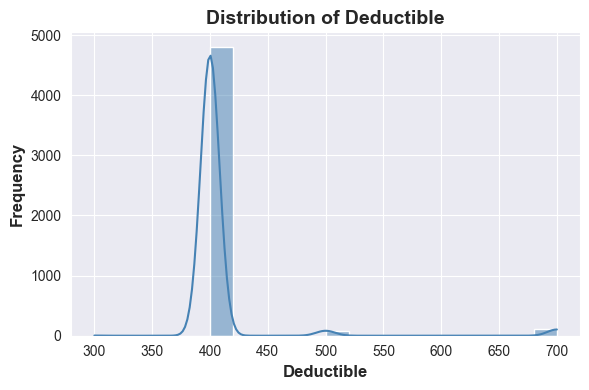

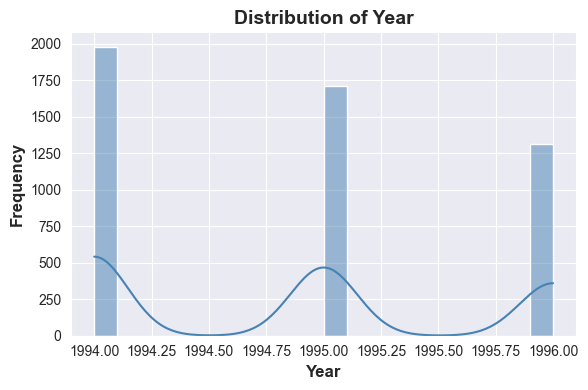

In [21]:
numeric_cols = df.select_dtypes(include = [np.number]).columns.drop(['FraudFound_P'])
print(len(numeric_cols))

for col in numeric_cols:
    plt.figure(figsize = (6,4))
    sns.histplot(df[col], kde = True, bins = 20, color = 'steelblue')
    plt.title(f'Distribution of {col}', fontsize = 14, fontweight = 'bold')
    plt.xlabel(col, fontsize = 12, fontweight = 'bold')
    plt.ylabel('Frequency', fontsize = 12, fontweight = 'bold')
    plt.tight_layout()
    plt.show()

## **2.4. Fraud Rate by Category — Key Findings**

>Using `n ≥ 50` to avoid volatility, we computed the fraud rate per category and compiled the **Hot Categories Table** (top 3 categories per variable by fraud rate). Below are the main signals that emerge consistently across variables:
>
>- **Policy / Coverage**
>  - `PolicyType = Utility - All Perils` (**10.71%**, n=112) and `Sedan - All Perils` (**10.05%**, n=1333) show **elevated fraud rates**.
>  - `BasePolicy = All Perils` (**10.05%**, n=1453) > `Collision` (**6.94%**, n=1903) >> `Liability` (**0.85%**, n=1644).
>
>- **Address change**
>  - `AddressChange_Claim = 2 to 3 years` (**16.48%**, n=91) and `1 year` (**9.23%**, n=65) are high; `no change` (**5.58%**, n=4626) is lower.  
>  - Interpretation: recent/mid‑term address changes may be fraud‑prone; keep these bins separated for WoE.
>
>- **Vehicle category & price**
>  - `VehicleCategory = Utility` (**8.96%**, n=134) and `Sedan` (**8.22%**, n=3114) > `Sport` (**1.37%**, n=1752).
>  - `VehiclePrice < 20,000` shows **10.86%** (n=350), higher than mid/high brackets.
>
>- **Fault & reporting**
>  - `Fault = Policy Holder` (**7.82%**, n=3643) >> `Third Party` (**0.52%**, n=1357).
>  - `PoliceReportFiled = Yes` (**2.21%**, n=136) is markedly **lower** than `No` (**5.94%**, n=4864).
>  - `WitnessPresent = No` at **5.84%** (n=4966). (Few “Yes” cases didn’t pass n ≥ 50.)
>
>- **Driver/vehicle age**
>  - `AgeOfVehicle = 4 years` (**9.86%**, n=71) and `new` (**8.59%**, n=128) are higher than several mid‑ages.
>  - `AgeOfPolicyHolder = 16–17` (**9.65%**, n=114) and `26–30` (**7.00%**, n=200) stand out; `31–35` is common with **6.54%** (n=1866).
>
>- **Temporal**
>  - `Month = Mar` (**8.62%**, n=441) and `Jan` (**7.19%**, n=459) appear above average; remember March has fewer cases overall, so confirm stability during modeling.
>
>- **Other skews**
>  - `AccidentArea = Rural` (**8.76%**, n=525) > `Urban` (**5.50%**, n=4475).
>  - `Make` is dominated by `Pontiac` (**6.36%**, n=1242); several premium/rare brands have higher rates but small n — keep under review.
>
>**Modeling implications (for WoE/scorecard):**
>- Keep **separate bins** for “All Perils” coverage, `Utility - All Perils`, recent **address changes**, **low vehicle price**, and **Policy Holder** fault — these show consistent uplift.  
>- Consider **merging very rare brands** and categories that do not meet `n ≥ 50`, unless they show a strong and stable signal.  
>- Interactions worth testing later: `BasePolicy × PolicyType`, `VehicleCategory × VehiclePrice`, `AccidentArea × Month`.
>
>*Note:* Only the **top-variance variables** were plotted to avoid clutter. The full results remain in the **Hot Categories Table**.

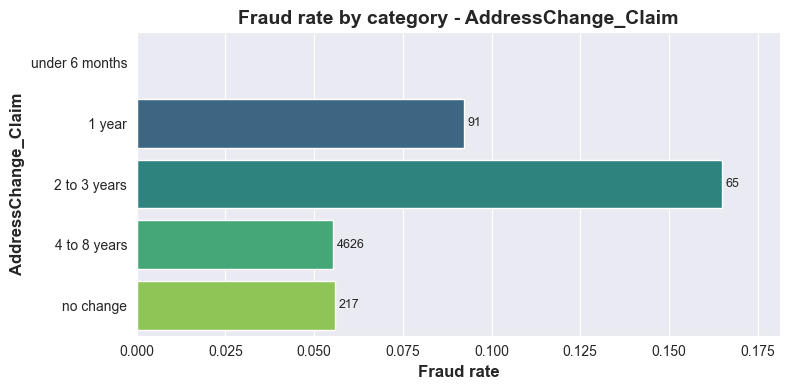

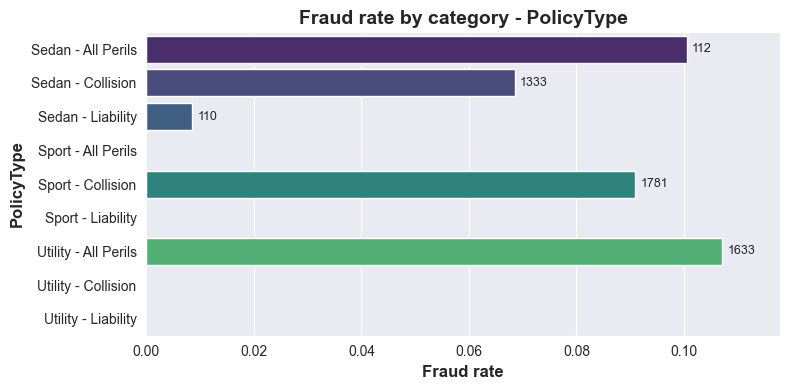

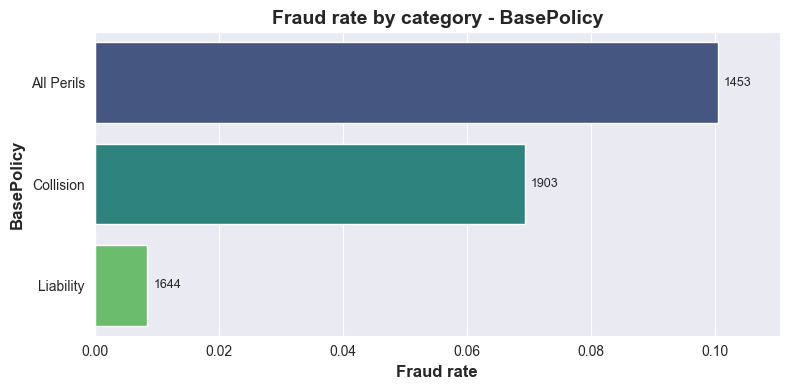

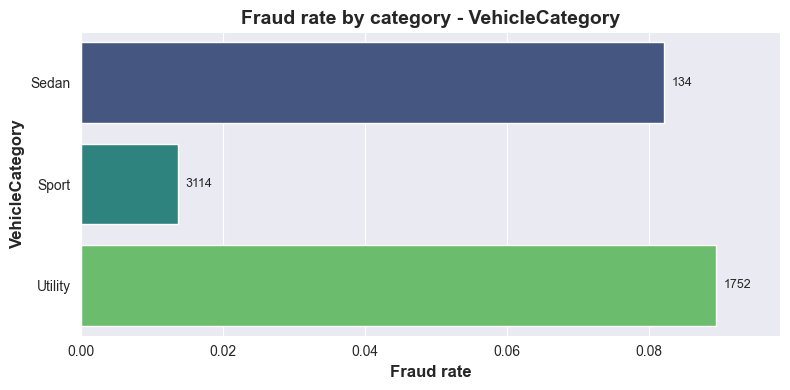

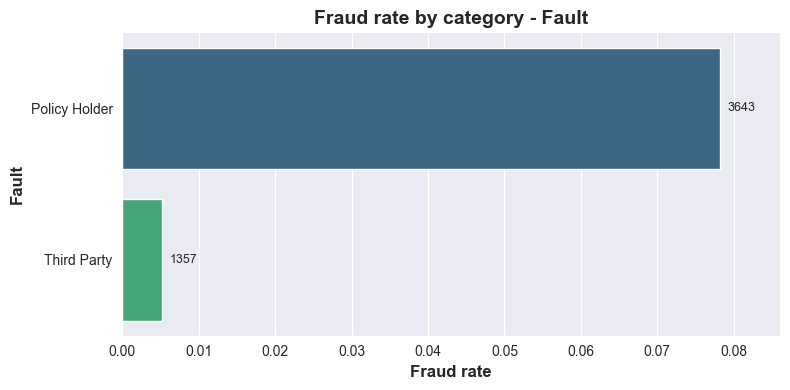

--------------------------------------------------------------------------------
Hot Categories Table (top fraud-rate categories with n >= {min_count})
--------------------------------------------------------------------------------
            variable             category fraud_rate    n
        AccidentArea                Rural      8.76%  525
        AccidentArea                Urban      5.50% 4475
 AddressChange_Claim         2 to 3 years     16.48%   91
 AddressChange_Claim               1 year      9.23%   65
 AddressChange_Claim            no change      5.58% 4626
   AgeOfPolicyHolder             16 to 17      9.65%  114
   AgeOfPolicyHolder             26 to 30      7.00%  200
   AgeOfPolicyHolder             31 to 35      6.54% 1866
        AgeOfVehicle              4 years      9.86%   71
        AgeOfVehicle                  new      8.59%  128
        AgeOfVehicle              5 years      8.31%  445
           AgentType             External      5.93% 4908
           Ag

In [22]:
min_count  = 50    # Minimum n per category to include to avoid overfitting.
top_n      = 3     # Top categories per variable (by fraud_rate).
show_all   = False # True = plot ALL categorical vars; False = only top_k_vars by spread.
top_k_vars = 5     # How many variables to plot when show_all = False.

hot_list    = [] # Top categories per variable (by fraud_rate).
spread_list = [] # to rank variables by spread if we don't want to plot everything.

def fraud_stats_by_category(frame: pd.DataFrame, col: str, min_n: int) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Compute fraud statistics by category.

    Parameters
    ----------
    frame : pd.DataFrame
        Input data
    col : str
        Categorical column to analyze
    min_n : int
        Minimum n per category to include

    Returns
    -------
    prop_df : pd.DataFrame
        Full stats (fraud_rate, n) for all categories
    plot_df : pd.DataFrame
        Filtered stats with n >= min_n
    top_df : pd.DataFrame
        Top_n categories from plot_df
    """
    prop_df = (
        frame.groupby(col, observed = True)['FraudFound_P']
             .agg(['mean', 'count'])
             .rename(columns = {'mean' : 'fraud_rate', 'count' : 'n'})
             .reset_index()
    )
    plot_df = prop_df[prop_df['n'] >= min_n].copy()
    if plot_df.empty:
        top_df = pd.DataFrame(columns = [col, 'fraud_rate', 'n'])
    else:
        top_df = plot_df.nlargest(top_n, 'fraud_rate').copy()
    return prop_df, plot_df, top_df

# Compute spreads to decide what to plot if show_all = False.
for col in categorical_cols:
    _, plot_df, top_df = fraud_stats_by_category(df, col, min_count)

    if not top_df.empty:
        tmp = top_df.copy()
        tmp['variable'] = col
        tmp = tmp[['variable', col, 'fraud_rate', 'n']]
        hot_list.append(tmp)

    if not plot_df.empty:
        spread = float(plot_df['fraud_rate'].max() - plot_df['fraud_rate'].min())
        spread_list.append((col, spread))

# Decide which variables to plot.
if show_all:
    cols_to_plot = list(categorical_cols)
else:
    # pick variables with largest fraud-rate spread (most “informative” visually).
    spread_df = pd.DataFrame(spread_list, columns = ['variable', 'spread']).sort_values('spread', ascending = False)
    cols_to_plot = spread_df['variable'].head(top_k_vars).tolist()

# Plot only the chosen variables.
for col in cols_to_plot:
    _, plot_df, _ = fraud_stats_by_category(df, col, min_count)
    if plot_df.empty:
        print(f"[Info] {col}: no category with n >= {min_count}; skipped plot.")
        continue

    plot_df = plot_df.sort_values('fraud_rate', ascending = False).reset_index(drop = True)
    plt.figure(figsize = (8,4))
    ax = sns.barplot(
        x = 'fraud_rate', y = col, data = plot_df, hue = col, dodge = False, legend = False, palette = 'viridis'
    )
    plt.title(f'Fraud rate by category - {col}', fontsize = 14, fontweight = 'bold')
    plt.xlabel('Fraud rate', fontsize = 12, fontweight = 'bold')
    plt.ylabel(col, fontsize = 12, fontweight = 'bold')
    for p, n in zip(ax.patches, plot_df['n'].tolist()):
        ax.text(p.get_width() + 0.001, p.get_y() + p.get_height()/2, f"{n}", va = 'center', fontsize = 9)
    xmax = max(0.01, float(plot_df['fraud_rate'].max()) * 1.1)
    plt.xlim(0, xmax)
    plt.tight_layout()
    plt.show()

# Build the hot categories table.
if hot_list:
    hot_table = pd.concat(hot_list, ignore_index = True)
    hot_table = hot_table.sort_values(by = ['variable', 'fraud_rate'], ascending = [True, False]).reset_index(drop = True)
    hot_table_out = hot_table.copy() # Copy for output
    hot_table_out['fraud_rate'] = (hot_table_out['fraud_rate'] * 100).round(2).map(lambda x: f"{x:.2f}%")

    # Reorder the columns.
    rows = []
    for _, r in hot_table_out.iterrows():
        var = r['variable']
        category_value = r[var]
        rows.append([var, category_value, r['fraud_rate'], int(r['n'])])
    hot_table_out = pd.DataFrame(rows, columns = ['variable', 'category', 'fraud_rate', 'n'])

    print(f"-" * 80 + "\nHot Categories Table (top fraud-rate categories with n >= {min_count})\n" + "-" * 80)
    print(hot_table_out.to_string(index = False))
else:
    print("[Info] No categories met the min_count threshold for any variable.")

## **2.5. Rare Levels (Low-Frequency Categories)**

>The rare level analysis, defined as categories with less than **1%** share or fewer than **20** occurrences, revealed several notable findings:  
>
>- **Extreme high cardinality** in `ID`, with over 5,000 unique categories, each occurring only once (no duplicates).  
>- In **`Make`**, several brands such as *Ferrari*, *Porsche*, *Mercedes*, or *Jaguar* appear in less than 0.05% of the records, making them statistically insignificant for modeling.  
>- Variables like `DayOfWeekClaimed` and `MaritalStatus` contain underrepresented categories (*Sunday*, *Saturday*, *Widow*, *Divorced*) which may affect statistical stability.  
>- In `PolicyType`, specific combinations such as *Sport - Liability* and *Utility - Liability* are extremely rare.  
>- Some variables contain virtually absent or zero-frequency categories:
>  - `Days_Policy_Accident` and `Days_Policy_Claim` have *none* categories or day ranges with very low counts.
>  - `PastNumberOfClaims` and `NumberOfSuppliments` have *none* categories with zero records.
>- Other isolated rare levels were detected in `AgeOfVehicle`, `AgeOfPolicyHolder`, `WitnessPresent`, `AddressChange_Claim`, and `NumberOfCars`.
>
>**Modeling Implications:**  
>- These categories may cause overfitting in machine learning models if not grouped, removed, or handled with robust encoding techniques.  
>- In cases of extreme high cardinality (e.g., `ID`), the variable may be irrelevant and should likely be dropped.  
>- Rare levels in otherwise important variables should be merged into an “Other” category to prevent excessive feature space fragmentation (I tried, but I didn't).

## **2.6. Information Value (IV) Analysis**

>The **Information Value (IV)** is a statistical measure used to evaluate the predictive power of a categorical variable for a binary target. It is calculated from the **Weight of Evidence (WOE)**, which compares the distribution of events (fraud cases) to non-events (non-fraud cases) for each category of a feature. The WOE for category *i* is defined as:
>$$
>\text{WOE}_i = \ln \left( \frac{\text{Distr\_Event}_i}{\text{Distr\_Non\_Event}_i} \right)
>$$
>
>The IV for a feature is the sum of the contributions from all its categories:
>
>$$
>\text{IV} = \sum_{i} (\text{Distr\_Event}_i - \text{Distr\_Non\_Event}_i) \times \text{WOE}_i
>$$
>
>Where:  
>- **Distr_Event**: proportion of fraud cases within the category.  
>- **Distr_Non_Event**: proportion of non-fraud cases within the category.
>
>### **IV Strength Interpretation**
>| IV Range   | Predictive Power       |
>|------------|------------------------|
>| < 0.02     | Weak                   |
>| 0.02–0.10  | Low                    |
>| 0.10–0.30  | Medium                  |
>| 0.30–0.50  | Strong                  |
>| > 0.50     | Suspicious / Possible Leakage |
>
>Values above **0.50** are considered **suspicious**, as they might indicate potential target leakage.
>
>### **Conclusions**
>- **PolicyType**, **Fault**, **BasePolicy**, and **VehicleCategory** have **very high IV values (> 0.50)**, suggesting extreme predictive power and a potential risk of **data leakage**. These features should be reviewed carefully before inclusion in the model.
>- Most other variables have **low predictive power (0.02–0.10)**, meaning they are not individually strong predictors but may contribute when used together in a multivariate model.
>- Several features (**Days_Policy_Accident**, **PoliceReportFiled**, **Sex**, **DayOfWeekClaimed**, etc.) show **weak predictive power (< 0.02)** and could be considered for removal unless domain knowledge suggests their relevance.

In [23]:
def calc_woe_iv_table(data: pd.DataFrame, feature: str, target: str) -> pd.DataFrame:
    """
    Returns a per-category table with counts, distributions, WOE and IV contribution.

    Parameters
    ----------
    data : pd.DataFrame
        Input data
    feature : str
        Categorical feature to analyze
    target : str
        Target variable (binary)

    Returns
    -------
    pd.DataFrame
        Table with WOE and IV for each category
    """
    ct = pd.crosstab(data[feature], data[target], dropna = False)
    ct = ct[[0,1]].rename(columns = {0: 'Non-Event', 1: 'Event'})

    # Distributions.
    eps = 1e-6 # To avoid divide by 0.
    ct['Distr_Event'] = ct['Event'] / max(ct['Event'].sum(), eps)
    ct['Distr_Non_Event'] = ct['Non-Event'] / max(ct['Non-Event'].sum(), eps)
    
    # WOE & IV contribution.
    ct['WOE'] = np.log((ct['Distr_Event'] + eps) / (ct['Distr_Non_Event'] + eps))
    ct['IV_contrib'] = (ct['Distr_Event'] - ct['Distr_Non_Event']) * ct['WOE']
    ct['Total'] = ct['Event'] + ct['Non-Event']

    return ct.reset_index().rename(columns = {feature: 'category'})

def calc_iv(data: pd.DataFrame, feature: str, target: str) -> float:
    """
    Compute Information Value (IV) for a categorical feature.

    Parameters
    ----------
    data : pd.DataFrame
        Input data
    feature : str
        Categorical feature to analyze
    target : str
        Target variable (binary)

    Returns
    -------
    float
        Information Value (IV) for the feature
    """
    tbl = calc_woe_iv_table(data, feature, target)

    return float(tbl['IV_contrib'].sum())

In [24]:
# Compute IV for all categorical predictors (exclude the target & ID).
iv_values = []
for col in categorical_cols:
    iv = calc_iv(df, col, 'FraudFound_P')
    iv_values.append((col, iv))

# Save IV DataFrame.
iv_df = (pd.DataFrame(iv_values, columns = ['Variable', 'IV']).sort_values('IV', ascending = False).reset_index(drop = True))

# Add IV strength bands.
def iv_band(x: float) -> str:
    """
    Assign IV strength band based on IV value.
    """
    if x < 0.02: return 'Weak'
    if x < 0.10: return 'Low'
    if x < 0.30: return 'Medium'
    if x < 0.50: return 'Strong'
    
    return 'Leakage?'

iv_df['Band'] = iv_df['IV'].apply(iv_band)

print("-" * 50 + "\nInformation Value (IV) Ranking\n" + "-" * 50)
print(iv_df.to_string(index = False))

--------------------------------------------------
Information Value (IV) Ranking
--------------------------------------------------
            Variable           IV     Band
          PolicyType 7.838322e-01 Leakage?
               Fault 7.345302e-01 Leakage?
          BasePolicy 7.344800e-01 Leakage?
     VehicleCategory 5.323556e-01 Leakage?
        AgeOfVehicle 8.711395e-02      Low
   AgeOfPolicyHolder 8.450877e-02      Low
        MonthClaimed 8.261603e-02      Low
 AddressChange_Claim 7.491494e-02      Low
               Month 7.293892e-02      Low
       MaritalStatus 6.655880e-02      Low
        VehiclePrice 5.994971e-02      Low
                Make 5.695358e-02      Low
  PastNumberOfClaims 4.176970e-02      Low
 NumberOfSuppliments 3.488672e-02      Low
  WeekOfMonthClaimed 3.069611e-02      Low
        AccidentArea 2.797028e-02      Low
           AgentType 2.777567e-02      Low
           DayOfWeek 2.699187e-02      Low
Days_Policy_Accident 1.865974e-02     Weak
   Poli

In [25]:
# Inspect WOE/IV table for the top-k variables
top_k      = 5
top_vars   = iv_df['Variable'].head(top_k).tolist()
woe_tables = {v: calc_woe_iv_table(df, v, 'FraudFound_P').sort_values('IV_contrib', ascending = False)
              for v in top_vars}
for var, table in woe_tables.items():
    display(table.style.format({
        "fraud_rate"      : "{:.2%}",
        "Distr_Event"     : "{:.2%}",
        "Distr_Non_Event" : "{:.2%}",
        "WOE"             : "{:.3f}",
        "IV_contrib"      : "{:.4f}"
    }))

FraudFound_P,category,Non-Event,Event,Distr_Event,Distr_Non_Event,WOE,IV_contrib,Total
2,Sedan - Liability,1619,14,4.79%,34.39%,-1.970,0.5831,1633
0,Sedan - All Perils,1199,134,45.89%,25.47%,0.589,0.1203,1333
7,Utility - Collision,12,0,0.00%,0.25%,-7.844,0.0200,12
8,Utility - Liability,10,0,0.00%,0.21%,-7.662,0.0163,10
6,Utility - All Perils,100,12,4.11%,2.12%,0.660,0.0131,112
3,Sport - All Perils,8,0,0.00%,0.17%,-7.439,0.0126,8
1,Sedan - Collision,1659,122,41.78%,35.24%,0.170,0.0111,1781
4,Sport - Collision,100,10,3.42%,2.12%,0.478,0.0062,110
5,Sport - Liability,1,0,0.00%,0.02%,-5.363,0.0011,1


FraudFound_P,category,Non-Event,Event,Distr_Event,Distr_Non_Event,WOE,IV_contrib,Total
1,Third Party,1350,7,2.40%,28.67%,-2.482,0.6521,1357
0,Policy Holder,3358,285,97.60%,71.33%,0.314,0.0824,3643


FraudFound_P,category,Non-Event,Event,Distr_Event,Distr_Non_Event,WOE,IV_contrib,Total
2,Liability,1630,14,4.79%,34.62%,-1.977,0.5897,1644
0,All Perils,1307,146,50.00%,27.76%,0.588,0.1308,1453
1,Collision,1771,132,45.21%,37.62%,0.184,0.0139,1903


FraudFound_P,category,Non-Event,Event,Distr_Event,Distr_Non_Event,WOE,IV_contrib,Total
1,Sport,1728,24,8.22%,36.70%,-1.496,0.4262,1752
0,Sedan,2858,256,87.67%,60.71%,0.368,0.0991,3114
2,Utility,122,12,4.11%,2.59%,0.461,0.0070,134


FraudFound_P,category,Non-Event,Event,Distr_Event,Distr_Non_Event,WOE,IV_contrib,Total
1,2 years,22,0,0.00%,0.47%,-8.450,0.0395,22
4,5 years,408,37,12.67%,8.67%,0.380,0.0152,445
6,7 years,1785,95,32.53%,37.91%,-0.153,0.0082,1880
7,more than 7,1207,63,21.58%,25.64%,-0.172,0.0070,1270
3,4 years,64,7,2.40%,1.36%,0.567,0.0059,71
5,6 years,1066,77,26.37%,22.64%,0.152,0.0057,1143
0,new,117,11,3.77%,2.49%,0.416,0.0053,128
2,3 years,39,2,0.68%,0.83%,-0.190,0.0003,41


# **3. Model**

## **3.1. Train/Test Split**

>To ensure an unbiased evaluation of the predictive model, the dataset was split into training and testing subsets **before** any Information Value (IV) calculation, Weight of Evidence (WOE) transformation, or model fitting. This approach prevents **data leakage**, where information from the test set could inadvertently influence the model during feature selection or transformation.
>
>Given the strong **class imbalance** in the target variable `FraudFound_P` (fraud rate ≈ 5.84%), a **stratified split** was applied. Stratification preserves the proportion of fraud (`1`) and non-fraud (`0`) cases across both subsets, ensuring representative distributions.
>
>- **Train set:** 3,500 records (70% of total) — fraud rate: **5.83%**.  
>- **Test set:** 1,500 records (30% of total) — fraud rate: **5.87%**.
>
>Data state: The split is performed on the preprocessed dataset from Sections `1.1 – 1.10`. No imputation, rare-level grouping, category merges, or feature drops are applied before the split. Any optional transformations will be fit on the training set only and then applied to the test set with frozen mappings.
>
>The training set will be used to:
>1. Compute IV and WOE values for categorical variables.  
>2. Train the logistic regression model.

In [26]:
class FraudModelPipeline:
    def __init__(self, df: pd.DataFrame, target: str, test_size: float = 0.3, seed: int = SEED):
        """
        Initialize the fraud detection model pipeline.

        Parameters
        ----------
        df : pd.DataFrame
            The input dataframe containing features and target variable.
        target : str
            The name of the target variable column.
        test_size : float, optional
            The proportion of the dataset to include in the test split (default is 0.3).
        seed : int, optional
            The random seed for reproducibility (default is SEED).
        """
        # Initialize variables.
        self.df        = df.copy() # Create a copy of the dataframe
        self.target    = target    # Name of the target variable
        self.test_size = test_size # Proportion of the dataset to include in the test split
        self.seed      = seed      # Random seed for reproducibility

        # Initialize training and test sets.
        self.X_tr = None
        self.X_te = None
        self.y_tr = None
        self.y_te = None

    def train_test_split_stratified(self) -> None:
        """
        Stratified split to preserve fraud/no fraud ratio.
        """
        X_full = self.df.drop(columns = [self.target])
        y_full = self.df[self.target]

        self.X_tr, self.X_te, self.y_tr, self.y_te = train_test_split(
            X_full, y_full, test_size = self.test_size, random_state = self.seed, stratify = y_full
        )

        print(f"Train size: {len(self.X_tr)} | Test size: {len(self.X_te)}")
        print(f"Fraud rate train: {self.y_tr.mean():.4f} | test: {self.y_te.mean():.4f}")

# NOTE: Using the preprocessed df (Sections 1.1–1.10) as-is: no imputation, no rare-level grouping, no drops yet.
df_raw = FraudModelPipeline(df, 'FraudFound_P')
df_raw.train_test_split_stratified()

Train size: 3500 | Test size: 1500
Fraud rate train: 0.0583 | test: 0.0587


## **3.2. Variable Selection and WOE Mapping**

>In this step, categorical predictors were evaluated based on their **Information Value (IV)** using **only the training set**. For each variable:
>
>1. The **WOE (Weight of Evidence)** table was computed, showing category-level statistics:
>       - Counts of events (fraud) and non-events.
>       - Distributions of events and non-events.
>       - WOE values per category.
>       - IV contribution per category.
>
>2. The **total IV** for the variable was calculated by summing the category-level contributions.
>
>3. Variables were selected according to the following rule:
>   - **Include**: $ 0.02 \leq \text{IV} \leq 0.50 $  
>     - Below `0.02`: weak predictive power.  
>     - Above `0.50`: suspiciously high predictive power (*potential data leakage*).  
>   - **Exclude**: variables outside this range.
>
>4. For each selected variable, a **mapping dictionary** `{category: WOE}` was created and stored in `woe_mappings` >for later transformation.
>
>**Selected variables (13 total):**
>`Month`, `Make`, `AccidentArea`, `DayOfWeekClaimed`, `MonthClaimed`, `WeekOfMonthClaimed`, `MaritalStatus`, >`VehiclePrice`, `AgeOfVehicle`, `AgeOfPolicyHolder`, `AgentType`, `AddressChange_Claim`, `NumberOfCars`.
>
>These mappings will be used to transform the dataset from categorical labels to their corresponding WOE values, >ensuring that the transformation applied to the training set will be consistently applied to the test set and any future data.

In [27]:
def variable_selection_woe(self, categorical_cols: list[str], iv_low: float = 0.02, iv_high: float = 0.50) -> None:
    """
    Select variables based on IV and create WOE mappings using only the training set.

    Parameters
    ----------
    categorical_cols : list[str]
        List of categorical columns to evaluate.
    iv_low : float, optional
        Lower bound for Information Value (IV) to consider a variable (default is 0.02).
    iv_high : float, optional
        Upper bound for Information Value (IV) to consider a variable (default is 0.50).
    """
    if self.X_tr is None or self.y_tr is None:
        raise ValueError("Run train_test_split_stratified() before variable selection.")

    self.woe_mappings = {}  # Dictionary to store WOE mappings for each variable.
    self.selected_vars = [] # List to store variables that pass the IV threshold.

    for col in categorical_cols:

        tbl_tr = calc_woe_iv_table( # Calculate WOE and IV for the variable using only the training set.
            pd.concat([self.X_tr[[col]], self.y_tr], axis = 1), col, self.target
        )
        iv_val = float(tbl_tr['IV_contrib'].sum()) # Compute the total IV value.

        if iv_low <= iv_val <= iv_high:
            woe_dict = dict(zip(tbl_tr['category'], tbl_tr['WOE'])) # Map categories to WOE values.
            self.woe_mappings[col] = woe_dict                       # Save mapping in dictionary.
            self.selected_vars.append(col)                          # Add variable to selection.

    print(f"Selected variables ({len(self.selected_vars)}):\n{self.selected_vars}")

# Add method to class.
FraudModelPipeline.variable_selection_woe = variable_selection_woe
df_raw.variable_selection_woe(categorical_cols)

Selected variables (13):
['Month', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'MaritalStatus', 'VehiclePrice', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'AgentType', 'AddressChange_Claim', 'NumberOfCars']


## **3.3. Applying Weight of Evidence (WOE) Transformation**

>A custom function `apply_woe` was defined to convert the categorical variables selected in **3.2** into their **Weight of Evidence (WOE)** numerical representation.  
>The function takes three arguments:  
>
>- **frame**: DataFrame to transform.  
>- **mappings**: dictionary mapping each variable to its WOE values (calculated from the training set).  
>- **vars_woe**: list of variables to apply the transformation.  
>
>Inside the function:  
>- The DataFrame is copied to avoid modifying the original data.  
>- For each variable, its categories are replaced by the corresponding WOE values from the `mappings` dictionary.  
>- Any category not present in the training mapping is assigned a neutral value of `0.0`.  
>
>The transformation is applied **separately** to the training (`X_tr`) and test (`X_te`) sets, always using the mappings learned from the training data to prevent data leakage.  
>Finally, both `X_tr_woe` and `X_te_woe` are filtered to contain only the selected variables, resulting in model-ready datasets in WOE scale.

In [28]:
def apply_woe(self, frame: pd.DataFrame, vars_woe: list[str] | None = None, fill_value: float = 0.0) -> pd.DataFrame:
    """
    Apply Weight of Evidence (WoE) transformation to the specified variables in the DataFrame.

    Parameters
    ----------
    frame : pd.DataFrame
        The input DataFrame to transform.
    vars_woe : list[str] | None
        A list of variable names to apply the WoE transformation.
    fill_value : float
        The value to use for missing mappings (default is 0.0).

    Returns
    -------
    pd.DataFrame
        A new DataFrame with the WoE transformation applied.
    """
    if not hasattr(self, "woe_mappings") or not self.woe_mappings:
        raise ValueError("Run variable_selection_woe() before apply_woe().")
    if vars_woe is None:
        if not hasattr(self, "selected_vars") or not self.selected_vars:
            raise ValueError("No selected_vars found. Provide vars_woe or run variable_selection_woe().")
        vars_woe = self.selected_vars

    out = frame.copy()
    for col in vars_woe:
        if col not in out.columns:
            raise KeyError(f"{col} not in frame.")
        out[col] = out[col].map(self.woe_mappings[col]).astype("float64").fillna(fill_value)
    return out

# Add method to class.
FraudModelPipeline.apply_woe = apply_woe

## **3.4 Logistic Regression Model with WoE-Transformed Variables**

>A logistic regression model was trained using the Weight of Evidence (WoE)–transformed variables obtained in the previous step.  
>The model was configured with the **LBFGS solver**, a maximum of **1000 iterations**, and **balanced class weights** to address class imbalance in the target variable. The training process produced the following coefficients for the selected variables:
>
>| Variable             | Coefficient |
>|----------------------|-------------|
>| Month                | 0.693246    |
>| Make                 | 1.032435    |
>| AccidentArea         | 0.838348    |
>| DayOfWeekClaimed     | 0.845718    |
>| MonthClaimed         | 0.631545    |
>| WeekOfMonthClaimed   | 1.150601    |
>| MaritalStatus        | 0.511065    |
>| VehiclePrice         | 1.044930    |
>| AgeOfVehicle         | 0.730000    |
>| AgeOfPolicyHolder    | 0.701525    |
>| AgentType            | 0.950642    |
>| AddressChange_Claim  | 1.118338    |
>| NumberOfCars         | 1.003997    |
>
>The model intercept was estimated at **0.000921**. These coefficients quantify the relationship between each WoE-transformed predictor and the log-odds of the dependent variable, `FraudFound_P`.

In [29]:
def fit_logistic_woe(self, solver: str = "lbfgs", max_iter: int = 1000, class_weight = "balanced") -> None:
    """
    Fit a Logistic Regression model on the WoE-transformed training data.

    Parameters
    ----------
    solver: str
        The solver to use for optimization.
    max_iter: int
        The maximum number of iterations for the solver.
    class_weight: str
        The class weight strategy to use.

    Requirements
    ------------
    - Call train_test_split_stratified() first (populates self.X_tr, self.y_tr).
    - Call variable_selection_woe() first (populates self.selected_vars, self.woe_mappings).
    - Ensure the class has an apply_woe() method attached.
    """
    # Basic checks to prevent leakage or missing setup.
    if self.X_tr is None or self.y_tr is None:
        raise ValueError("Run train_test_split_stratified() before fitting the model.")
    if not getattr(self, "selected_vars", None):
        raise ValueError("Run variable_selection_woe() to set self.selected_vars and self.woe_mappings.")
    if not getattr(self, "woe_mappings", None):
        raise ValueError("WoE mappings not found. Run variable_selection_woe() first.")
    if not hasattr(self, "apply_woe"):
        raise ValueError("attach apply_woe() to the class before fitting.")

    # Transform the training features into WoE scale using mappings learned on train.
    X_tr_woe = self.apply_woe(self.X_tr, self.selected_vars)
    X_tr_woe = X_tr_woe[self.selected_vars]  # lock column order to match coefficients.

    # Initialize and fit the logistic regression.
    self.model_ = LogisticRegression(solver = solver, max_iter = max_iter, class_weight = class_weight)
    self.model_.fit(X_tr_woe, self.y_tr)

    # Store fitted artifacts for later reference/reporting
    self.feature_order_ = list(self.selected_vars)  # the exact order used during training
    self.coefs_ = pd.DataFrame(
        {
            "Variable"    : self.feature_order_,
            "Coefficient" : self.model_.coef_[0]
        }
    )
    self.intercept_ = float(self.model_.intercept_[0])

    # Print a quick summary.
    print(self.coefs_)
    print("Intercept:", self.intercept_)

# Attach method to the existing class
FraudModelPipeline.fit_logistic_woe = fit_logistic_woe
df_raw.fit_logistic_woe()

               Variable  Coefficient
0                 Month     0.693246
1                  Make     1.032435
2          AccidentArea     0.838348
3      DayOfWeekClaimed     0.845718
4          MonthClaimed     0.631545
5    WeekOfMonthClaimed     1.150601
6         MaritalStatus     0.511065
7          VehiclePrice     1.044930
8          AgeOfVehicle     0.730000
9     AgeOfPolicyHolder     0.701525
10            AgentType     0.950642
11  AddressChange_Claim     1.118338
12         NumberOfCars     1.003997
Intercept: 0.0009210205543104894


## **3.5. Scorecard Construction**

>A points-based scorecard was derived from the logistic model trained on WOE-transformed variables.
>
>**Scale parameters**
>- **PDO** (Points to Double the Odds): 20  
>- **BASE_SCORE**: 600  
>- **BASE_ODDS**: 50:1  
>- Factor: `PDO / ln(2)`  
>- Offset: `BASE_SCORE - factor * ln(BASE_ODDS)`  
>- Intercept points: `- factor * intercept` → **-0** (intercept ~ 0)
>
>**Per-category points**
>For each variable and category:
>$$
>\text{Points} = -\, (\text{coeficiente}_\text{var}) \times \text{WOE}_\text{categoría} \times \text{factor}
>$$
>(El signo negativo garantiza que **mayor riesgo → menos puntos**.)
>
>**Ejemplo (muestra de filas)**
>- `AccidentArea = Rural`: WOE = 0.393, Coef = 0.838 → **-10 pts**  
>- `AccidentArea = Urban`: WOE = -0.061, Coef = 0.838 → **+1 pt**  
>- `AddressChange_Claim = under 6 months`: WOE = 8.498, Coef = 1.118 → **-274 pts**  
>- `AddressChange_Claim = 2 to 3 years`: WOE = 1.278, Coef = 1.118 → **-41 pts**  
>- `AddressChange_Claim = 1 year`: WOE = 0.563, Coef = 1.118 → **-18 pts**
>
>The full scorecard (`scorecard_df`) lists **Variable, Category, WOE, Coef, Points** for all categories, sorted for readability.

In [ ]:
def build_scorecard(
        self, PDO: float = 20.0, BASE_SCORE: float = 600.0, BASE_ODDS: float = 50.0, round_points: int = 0
        ) -> None:
    """
    Construct a points-based scorecard from the fitted logistic model on WoE features.

    Parameters
    ----------
    PDO : float
        Points to Double the Odds.
    BASE_SCORE : float
        Base score on the chosen scale.
    BASE_ODDS : float
        Base odds at the base score (e.g., 50:1).
    round_points : int
        Number of decimals to round the per-category points (0 for integer points).
    
    Requirements
    ------------
    - fit_logistic_woe() must have been called (populates self.model_, self.coefs_, self.intercept_).
    - variable_selection_woe() must have been called (populates self.selected_vars and self.woe_mappings).
    """
    # Basic checks.
    if not hasattr(self, "model_"):
        raise ValueError("Fit the logistic model first (fit_logistic_woe()).")
    if not getattr(self, "selected_vars", None) or not getattr(self, "woe_mappings", None):
        raise ValueError("Run variable_selection_woe() before building the scorecard.")

    # Scale parameters.
    factor = PDO / np.log(2.0)                          # Factor to convert odds to points.
    offset = BASE_SCORE - factor * np.log(BASE_ODDS)    # Offset to align scorecard.
    intercept_points = -factor * float(self.intercept_) # include model intercept in the score.

    # For later reference.
    self.score_params_ = {
        "PDO"              : PDO,
        "BASE_SCORE"       : BASE_SCORE,
        "BASE_ODDS"        : BASE_ODDS,
        "factor"           : factor,
        "offset"           : offset,
        "intercept_points" : intercept_points,
    }

    # Build scorecard rows.
    rows = []
    # Map variable -> coefficient (aligned to feature order used in training)
    coef_by_var = dict(zip(self.feature_order_, self.model_.coef_[0]))

    for var in self.selected_vars:
        coef = float(coef_by_var[var])
        # categories and WOE values learned on train
        for category, woe in self.woe_mappings[var].items():
            pts = -coef * float(woe) * factor
            rows.append({
                "Variable" : var,
                "Category" : category,
                "WOE"      : float(woe),
                "Coef"     : coef,
                "Points"   : np.round(pts, round_points),
            })

    # Build and store the scorecard table.
    scorecard_df = (pd.DataFrame(rows).sort_values(["Variable", "Points"], ascending = [True, True]).reset_index(drop = True))

    self.scorecard_df_ = scorecard_df
    self.intercept_points_ = np.round(intercept_points, round_points)

    # Quick summary print.
    #print("Intercept points (constant):", self.intercept_points_)
    #display(scorecard_df.head())

# Add method to class.
FraudModelPipeline.build_scorecard = build_scorecard

In [36]:
df_raw.build_scorecard(PDO = 20, BASE_SCORE = 600, BASE_ODDS = 50, round_points = 0)
scorecard_path = "artifacts/scorecard.csv"
df_raw.scorecard_df_.to_csv(scorecard_path, index = False, encoding = "utf-8-sig")

with open("artifacts/scorecard_intercept.txt", "w", encoding = "utf-8") as f:
    f.write(f"Intercept points (constant): {df_raw.intercept_points_}\n")

print(f"Scorecard saved in: {scorecard_path}")
print("Intercept saved in: artifacts/scorecard_intercept.txt")

Scorecard saved in: artifacts/scorecard.csv
Intercept saved in: artifacts/scorecard_intercept.txt


### **3.5.1. Client Score Calculation**

>The **`calculate_score`** function computes the total score for a given client based on the scorecard model coefficients and Weight of Evidence (WOE) mappings.  
>It starts with the **offset** and **intercept points**, then iterates through each variable in the client's profile:
>
>1. **WOE Lookup:** Retrieves the WOE value for the client's category, defaulting to `0.0` if not found.
>2. **Coefficient Retrieval:** Looks up the logistic regression coefficient corresponding to the variable.
>3. **Points Update:** Adjusts the score using the formula `-coef * WOE * factor`.
>
>The result is rounded to the nearest integer.
>
>**Example:**  
>The example computes the score for the first client in the test dataset, resulting in:

In [31]:
def calculate_score(self, client: dict, round_points: int = 0) -> float:
    """
    Compute the total score for a single client using the trained logistic model,
    WoE mappings learned on train, and the scorecard scale parameters.

    Requirements
    ------------
    - fit_logistic_woe() has been called (populates self.model_, self.feature_order_, self.intercept_).
    - build_scorecard() has been called (populates self.score_params_, self.woe_mappings).

    Parameters
    ----------
    client : dict
        Mapping {variable: raw category value} for the client.
    round_points : int
        Number of decimals to round the final score (0 for integer score).

    Returns
    -------
    float
        Client total score.
    """
    if not hasattr(self, "score_params_"):
        raise ValueError("Run build_scorecard() first to set score scale parameters.")
    if not getattr(self, "woe_mappings", None):
        raise ValueError("WoE mappings not found. Run variable_selection_woe().")
    if not hasattr(self, "model_"):
        raise ValueError("Model not fitted. Run fit_logistic_woe().")

    factor = self.score_params_["factor"]
    offset = self.score_params_["offset"]
    intercept_points = self.score_params_["intercept_points"]

    # Map variable -> coefficient (aligned with training feature order)
    coef_by_var = dict(zip(self.feature_order_, self.model_.coef_[0]))

    total = offset + intercept_points

    # Iterate only over variables we actually model
    for var in self.feature_order_:
        # raw category value from the client
        val = client.get(var, None)
        # WoE lookup (default to 0.0 if unseen/missing)
        w = self.woe_mappings.get(var, {}).get(val, 0.0)
        coef = float(coef_by_var[var])
        total += -coef * float(w) * factor

    return float(np.round(total, round_points))

# Attach to class.
FraudModelPipeline.calculate_score = calculate_score

# Build client dict from the first test row using the selected vars.
example_client = {var: df_raw.X_te[var].iloc[0] for var in df_raw.selected_vars}
print("Example score:", df_raw.calculate_score(example_client, round_points = 0))

Example score: 466.0


# **4. Evaluation**

4.8 Métricas en TEST (ROC-AUC, PR-AUC, KS, matriz)


In [32]:
def evaluate_test(self, plot: bool = True) -> Dict[str, Any]:
    """
    Evaluate the fitted model on the test set. Computes ROC-AUC, PR-AUC, KS (with its threshold),
    confusion matrix @ KS, and optionally displays plots.

    Parameters
    ----------
    plot : bool
        Whether to display plots.

    Returns
    -------
    dict with keys:
      'roc_auc', 'pr_auc', 'ks', 'ks_threshold', 'confusion_matrix', 'precision_at_ks', 'recall_at_ks'

    Requirements
    ------------
    - fit_logistic_woe() must have been called (populates self.model_).
    - variable_selection_woe() + apply_woe() available if WoE features are needed.
    """
    if not hasattr(self, "model_"):
        raise ValueError("Model not fitted. Call fit_logistic_woe() first.")

    # Ensure WoE-transformed test features are in the same order as training.
    if hasattr(self, "X_te_woe_"):
        X_te_woe = self.X_te_woe_[self.feature_order_]
    else:
        X_te_woe = self.apply_woe(self.X_te, self.selected_vars)[self.feature_order_]

    # 1) Predicted probabilities on test. logits.
    proba_te = self.model_.predict_proba(X_te_woe)[:,1]

    # 2) ROC / AUC.
    roc_auc = roc_auc_score(self.y_te, proba_te)
    fpr, tpr, thr = roc_curve(self.y_te, proba_te)

    # 3) KS (align arrays safely).
    n_thr   = len(thr)
    n_rates = min(len(tpr) - 1, len(fpr) - 1, n_thr)
    thr_aln = thr[:n_rates]
    tpr_aln = tpr[1:1 + n_rates]
    fpr_aln = fpr[1:1 + n_rates]
    ks_vals = tpr_aln - fpr_aln
    ks_idx  = int(np.argmax(ks_vals))
    ks      = float(ks_vals[ks_idx])
    thr_ks  = float(thr_aln[ks_idx])

    # 4) Precision–Recall / AP.
    prec_curve, rec_curve, thr_pr = precision_recall_curve(self.y_te, proba_te)
    pr_auc = average_precision_score(self.y_te, proba_te)

    # 5) Confusion matrix @ KS threshold.
    y_hat = (proba_te >= thr_ks).astype(int)
    cm = confusion_matrix(self.y_te, y_hat)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)

    # 6) Print numeric results
    print(f"ROC-AUC: {roc_auc:.3f} | PR-AUC: {pr_auc:.3f} | KS: {ks:.3f} @ thr={thr_ks:.3f}")
    print("Confusion matrix @ KS:\n", cm)
    print(f"Precision: {precision:.3f} | Recall: {recall:.3f}")

    # 7) Plots
    if plot:
        # (a) Confusion Matrix Heatmap @ KS.
        fig, ax = plt.subplots(figsize = (7,5))
        sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Purples',
                    xticklabels = ['Pred 0', 'Pred 1'],
                    yticklabels = ['True 0', 'True 1'],
                    ax = ax)
        ax.set_title("Confusion Matrix @ KS Threshold", fontsize = 16, fontweight = 'bold')
        ax.set_xlabel("Predicted Label", fontsize = 12)
        ax.set_ylabel("True Label", fontsize = 12)
        plt.tight_layout(); plt.show()

        # (b) ROC Curve.
        fig, ax = plt.subplots(figsize = (7,5))
        ax.plot(fpr, tpr, label = f'ROC curve (AUC = {roc_auc:.3f})')
        ax.plot([0,1], [0,1], 'k--', linewidth = 1)
        ax.set_title("ROC Curve", fontsize = 16, fontweight = 'bold')
        ax.set_xlabel("False Positive Rate", fontsize = 12)
        ax.set_ylabel("True Positive Rate", fontsize = 12)
        ax.legend(loc = 'best')
        plt.tight_layout(); plt.show()

        # (c) Precision-Recall Curve.
        fig, ax = plt.subplots(figsize = (7,5))
        ax.plot(rec_curve, prec_curve, label=f'PR curve (AP = {pr_auc:.3f})')
        ax.set_title("Precision-Recall Curve", fontsize = 16, fontweight = 'bold')
        ax.set_xlabel("Recall", fontsize = 12)
        ax.set_ylabel("Precision", fontsize = 12)
        ax.legend(loc = 'best')
        plt.tight_layout(); plt.show()

        # (d) KS Curve
        fig, ax = plt.subplots(figsize = (7,5))
        ax.plot(thr_aln, tpr_aln, label = 'TPR')
        ax.plot(thr_aln, fpr_aln, label = 'FPR')
        ax.axvline(thr_ks, linestyle = '--', linewidth = 1, color = 'red', label = f'KS thr={thr_ks:.3f}')
        ax.set_title(f"KS Curve (KS = {ks:.3f})", fontsize = 16, fontweight = 'bold')
        ax.set_xlabel("Decision Threshold", fontsize = 12)
        ax.set_ylabel("Rate", fontsize = 12)
        ax.legend(loc = 'best')
        plt.tight_layout(); plt.show()

    return {
        "roc_auc"          : roc_auc,
        "pr_auc"           : pr_auc,
        "ks"               : ks,
        "ks_threshold"     : thr_ks,
        "confusion_matrix" : cm,
        "precision_at_ks"  : precision,
        "recall_at_ks"     : recall,
    }

# Attach to the FraudModelPipeline class.
FraudModelPipeline.evaluate_test = evaluate_test

ROC-AUC: 0.538 | PR-AUC: 0.076 | KS: 0.108 @ thr=0.723
Confusion matrix @ KS:
 [[1324   88]
 [  74   14]]
Precision: 0.137 | Recall: 0.159


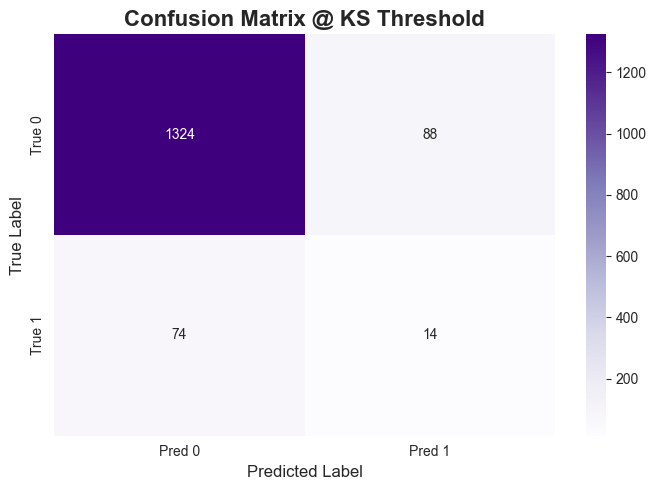

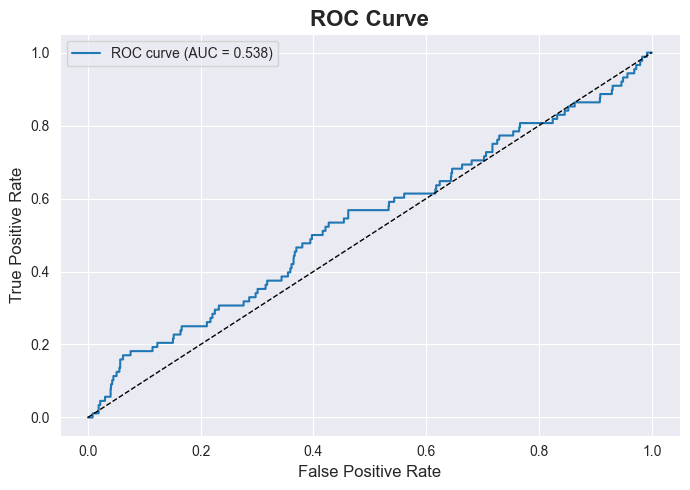

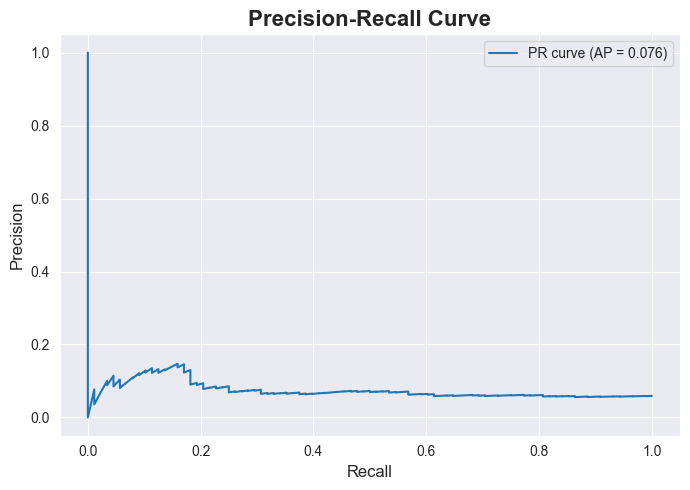

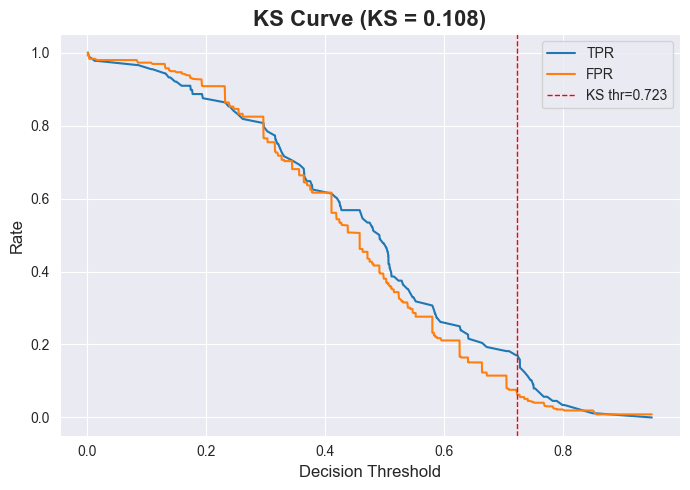

In [33]:
metrics = df_raw.evaluate_test(plot = True)

# **API**

In [34]:
ART_DIR = "artifacts"
os.makedirs(ART_DIR, exist_ok = True)

with open(os.path.join(ART_DIR, "selected_vars.json"), "w") as f:
    json.dump(df_raw.selected_vars, f)

woe_mappings_json = {k: {str(cat): float(woe) for cat, woe in v.items()} 
                     for k, v in df_raw.woe_mappings.items()}
with open(os.path.join(ART_DIR, "woe_mappings.json"), "w") as f:
    json.dump(woe_mappings_json, f)

coef_by_var = dict(zip(df_raw.feature_order_, df_raw.model_.coef_[0].tolist()))
with open(os.path.join(ART_DIR, "coefficients.json"), "w") as f:
    json.dump({k: float(v) for k, v in coef_by_var.items()}, f)

with open(os.path.join(ART_DIR, "intercept.json"), "w") as f:
    json.dump({"intercept": float(df_raw.intercept_)}, f)

with open(os.path.join(ART_DIR, "score_params.json"), "w") as f:
    json.dump(
        {
            "PDO"              : float(df_raw.score_params_["PDO"]),
            "BASE_SCORE"       : float(df_raw.score_params_["BASE_SCORE"]),
            "BASE_ODDS"        : float(df_raw.score_params_["BASE_ODDS"]),
            "factor"           : float(df_raw.score_params_["factor"]),
            "offset"           : float(df_raw.score_params_["offset"]),
            "intercept_points" : float(df_raw.intercept_points_),
        }, f
    )

with open(os.path.join(ART_DIR, "version.json"), "w") as f:
    json.dump({"model_version": "v1.0", "seed": int(df_raw.seed)}, f)

print("Artifacts written to ./artifacts")

Artifacts written to ./artifacts


In [35]:
# Generate en example to test the API from test set.
row = df_raw.X_te.iloc[0]

example_client = {}
for var in df_raw.selected_vars:
    val = row[var]
    if pd.api.types.is_numeric_dtype(df_raw.X_te[var].dtype):
        example_client[var] = float(val) if pd.notna(val) else None
    else:
        example_client[var] = str(val) if pd.notna(val) else None

payload = {"data": example_client}

print(json.dumps(payload, indent=2))
with open("sample_payload.json", "w") as f:
    json.dump(payload, f, indent=2)
print("Wrote sample_payload.json")

{
  "data": {
    "Month": "Jan",
    "Make": "Pontiac",
    "AccidentArea": "Urban",
    "DayOfWeekClaimed": "Monday",
    "MonthClaimed": "Jan",
    "WeekOfMonthClaimed": "4",
    "MaritalStatus": "Married",
    "VehiclePrice": "less than 20000",
    "AgeOfVehicle": "more than 7",
    "AgeOfPolicyHolder": "41 to 50",
    "AgentType": "External",
    "AddressChange_Claim": "no change",
    "NumberOfCars": "1 vehicle"
  }
}
Wrote sample_payload.json
